In [1]:
library(dplyr)
library(tidyr)
library(rstatix)
library(ggrepel)
library(ggplot2)
library(Hmisc)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ggsci)
library(ggpubr)
library(cicero)
library(GenomicInteractions)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(WebGestaltR)
library(plotgardener)
library(ggridges)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Loading required package: ggplot2

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, 

In [2]:
projdir <- '/nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis'

In [369]:
source(file.path(projdir,'ArchR_utilities.R'))

# Load Data

In [4]:
all_MuSC_cds.cicero <- readRDS(file.path(projdir, "MuSC_subset", "Cicero_objects", "all_MuSC_cicero.RDS"))
young_MuSC_cds.cicero <- readRDS(file.path(projdir, "MuSC_subset", "Cicero_objects", "young_MuSC_cicero.RDS"))
aged_MuSC_cds.cicero <- readRDS(file.path(projdir, "MuSC_subset", "Cicero_objects", "aged_MuSC_cicero.RDS"))

In [5]:
load(file.path(projdir, "MuSC_subset", "Cicero_objects", "Aged_MuSC_cicero_conns_ccans.RData"))
aged_conns <- conns
aged_ccans <- ccans

load(file.path(projdir, "MuSC_subset", "Cicero_objects", "Young_MuSC_cicero_conns_ccans.RData"))
young_conns <- conns
young_ccans <- ccans

load(file.path(projdir, "MuSC_subset", "Cicero_objects", "all_MuSC_MuSC_cicero_conns_ccans.RData"))
all_conns <- conns
all_ccans <- ccans

In [6]:
rm(list = c("conns","ccans"))
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,13632502,728.1,26743635,1428.3,18012040,962.0
Vcells,100027938,763.2,130107384,992.7,100155244,764.2


In [7]:
tpm.data <- readRDS(file.path(projdir, 'filtered_tpm_data.RDS'))

In [8]:
DE.genes.name <- read.table("/nas/homes/benyang/HiC/04_FANC/compartmentExpression/DE_0.05padj_log2(1.5)LFC_genenames.tsv", sep='\t')

In [9]:
clustered_p2g <- readRDS(file.path(projdir, 'MuSC_subset', 'all_MuSCs', 'all_MuSC_peak2gene_clustered.RDS'))

In [10]:
p2g_bedpe <- readRDS(file.path(projdir, 'output', 'Peak2GeneLinks', 'all_MuSC_p2g_bedpe.RDS'))

In [11]:
aged.domain <- read.table("/nas/homes/benyang/HiC/08_HiCExplorer/aged.merged/40kb/aged.merged_min120kb_max1200kb_step40kb_thresh0.01_delta_0.01_fdr_domains.bed")
aged.domain.ranges <- GRanges(aged.domain[,1:5] %>% setNames(c("chr","start","end","ID","score")))

young.domain <- read.table("/nas/homes/benyang/HiC/08_HiCExplorer/young.merged/40kb/young.merged_min120kb_max1200kb_step40kb_thresh0.01_delta_0.01_fdr_domains.bed")
young.domain.ranges <- GRanges(young.domain[,1:5] %>% setNames(c("chr","start","end","ID","score")))

In [12]:
loopdir="/nas/homes/benyang/HiC/05_Arrowhead_HICCUPS"

young_loop=read.table(file.path(loopdir,"young_merged_hiccups","young_merged_loops_noHeader.bedpe"),
                      col.names = c("chromosome1","x1","x2",
                                    "chromosome2","y1","y2",
                                    "blank1","blank2","blank3","blank4",
                                    "color","observed",
                                    "expected_bottom_left","expected_donut","expected_horizontal","expected_vertical",
                                    "fdr_bottom_left","fdr_donut","fdr_horizontal","fdr_vertical",
                                    "number_collapsed","centroid1","centroid2","radius"))
aged_loop=read.table(file.path(loopdir,"aged_merged_hiccups","aged_merged_loops_noHeader.bedpe"),
                     col.names = c("chromosome1","x1","x2",
                                   "chromosome2","y1","y2",
                                   "blank1","blank2","blank3","blank4",
                                   "color","observed",
                                   "expected_bottom_left","expected_donut","expected_horizontal","expected_vertical",
                                   "fdr_bottom_left","fdr_donut","fdr_horizontal","fdr_vertical",
                                   "number_collapsed","centroid1","centroid2","radius"))
young_loop$Age="Y"
aged_loop$Age="A"

# Get gene TSS coordinates

In [7]:
gene_anno <- rtracklayer::readGFF('/nas/homes/benyang/Genome_References/gencode.vM25.annotation.gff3.gz')
# rename some columns to match requirements
gene_anno$chromosome <- gene_anno$seqid
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_id
gene_anno$symbol <- gene_anno$gene_name

saveRDS(gene_anno, file.path(projdir, "gene_anno.RDS"))

In [17]:
gene_anno <- readRDS(file.path(projdir, 'gene_anno.RDS'))

In [43]:
# Create a gene annotation set that only marks the transcription start sites of 
# the genes. We use this as a proxy for promoters.
# To do this we need the first exon of each transcript
pos <- subset(gene_anno, strand == "+")
pos <- pos[order(pos$start),] 
# remove all but the first exons per transcript
pos <- pos[!duplicated(pos$symbol),] 
# make a 1 base pair marker of the TSS
pos$end <- pos$start + 1 

neg <- subset(gene_anno, strand == "-")
neg <- neg[order(neg$start, decreasing = TRUE),] 
# remove all but the first exons per transcript
neg <- neg[!duplicated(neg$symbol),] 
neg$start <- neg$end - 1

gene_anno_tss <- rbind(pos, neg)

saveRDS(gene_anno_tss, file.path(projdir, "gene_anno_tss.RDS"))

In [48]:
# Make a subset of the TSS annotation columns containing just the coordinates 
# and the gene name
gene_anno_tss <- gene_anno_tss[,c("chromosome", "start", "end", "strand", "symbol")]
names(gene_anno_tss)[5] <- "gene"

In [50]:
GRanges(gene_anno_tss)

GRanges object with 55293 ranges and 1 metadata column:
          seqnames    ranges strand |        gene
             <Rle> <IRanges>  <Rle> | <character>
      [1]     chrM       1-2      + |       mt-Tf
      [2]     chrM     70-71      + |     mt-Rnr1
      [3]     chrM 1025-1026      + |       mt-Tv
      [4]     chrM 1094-1095      + |     mt-Rnr2
      [5]     chrM 2676-2677      + |      mt-Tl1
      ...      ...       ...    ... .         ...
  [55289]     chrM 5325-5326      - |       mt-Ty
  [55290]     chrM 5256-5257      - |       mt-Tc
  [55291]     chrM 5158-5159      - |       mt-Tn
  [55292]     chrM 5085-5086      - |       mt-Ta
  [55293]     chrM 3841-3842      - |       mt-Tq
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

## Define promoters

In [476]:
tss_slop_1kb <- read.table('/nas/homes/benyang/Genome_References/tss.1kb_slop.gencode.vM25.basic.annotation.bed')
colnames(tss_slop_1kb) <- c("chr","start","end","gene","score","strand")
tss_slop_1kb <- GRanges(tss_slop_1kb)
tss_slop_1kb

GRanges object with 55381 ranges and 2 metadata columns:
          seqnames            ranges strand |        gene       score
             <Rle>         <IRanges>  <Rle> | <character> <character>
      [1]     chr1   3101016-3103017      + |     Gm26206           .
      [2]     chr1   3251757-3253758      + |     Gm18956           .
      [3]     chr1   3367548-3369549      - |     Gm37180           .
      [4]     chr1   3376787-3378788      - |     Gm37363           .
      [5]     chr1   3465587-3467588      + |      Gm1992           .
      ...      ...               ...    ... .         ...         ...
  [55377]     chrY 90752057-90754058      + |    Mid1-ps1           .
  [55378]     chrY 90754466-90756467      - |     Gm21860           .
  [55379]     chrY 90783738-90785739      + |     Gm47283           .
  [55380]     chrY 90836413-90838414      + |     Gm21742           .
  [55381]     chrY 90838176-90840177      - |     Gm21748           .
  -------
  seqinfo: 22 sequences

In [22]:
# tss_slop_1kb <- promoters(EnsDb.Mmusculus.v79, upstream = 1000, downstream = 1000)
# genome <- GRanges(Seqinfo(genome = "mm10"))
# for(chr in unique(seqnames(tss_slop_1kb))) {
#     chr_subset <- tss_slop_1kb[seqnames(tss_slop_1kb)==chr, ]
#     start_outofbounds_idx <- which(start(chr_subset) < 1)
#     end_outofbounds_idx <- which(end(chr_subset) > end(genome[seqnames(genome)==chr, ]))
#     start(tss_slop_1kb[seqnames(tss_slop_1kb)==chr, ])[start_outofbounds_idx] <- 1
#     end(tss_slop_1kb[seqnames(tss_slop_1kb)==chr, ])[end_outofbounds_idx] <- end(genome[seqnames(genome)==chr, ])
# }

# saveRDS(tss_slop_1kb, file.path(projdir, "tss_slop_1kb.RDS"))

## Annotate cicero objects

In [477]:
young_MuSC_cds.cicero <- annotate_cds_by_site(young_MuSC_cds.cicero, as.data.frame(tss_slop_1kb), header=T, all=T)
aged_MuSC_cds.cicero <- annotate_cds_by_site(aged_MuSC_cds.cicero, as.data.frame(tss_slop_1kb), header=T, all=T)
all_MuSC_cds.cicero <- annotate_cds_by_site(all_MuSC_cds.cicero, as.data.frame(tss_slop_1kb), header=T, all=T)

head(fData(young_MuSC_cds.cicero))
head(fData(aged_MuSC_cds.cicero))
head(fData(all_MuSC_cds.cicero))

DataFrame with 6 rows and 8 columns
                                site_name         chr       bp1       bp2
                              <character> <character> <numeric> <numeric>
chr1_3670539_3671039 chr1_3670539_3671039           1   3670539   3671039
chr1_3671560_3672060 chr1_3671560_3672060           1   3671560   3672060
chr1_4571643_4572143 chr1_4571643_4572143           1   4571643   4572143
chr1_4785442_4785942 chr1_4785442_4785942           1   4785442   4785942
chr1_4807545_4808045 chr1_4807545_4808045           1   4807545   4808045
chr1_4857435_4857935 chr1_4857435_4857935           1   4857435   4857935
                     num_cells_expressed     overlap           gene       score
                               <integer> <character>    <character> <character>
chr1_3670539_3671039                  33         501           Xkr4           .
chr1_3671560_3672060                 131         501           Xkr4           .
chr1_4571643_4572143                 109          NA

DataFrame with 6 rows and 8 columns
                                site_name         chr       bp1       bp2
                              <character> <character> <numeric> <numeric>
chr1_3670539_3671039 chr1_3670539_3671039           1   3670539   3671039
chr1_3671560_3672060 chr1_3671560_3672060           1   3671560   3672060
chr1_4571643_4572143 chr1_4571643_4572143           1   4571643   4572143
chr1_4785442_4785942 chr1_4785442_4785942           1   4785442   4785942
chr1_4807545_4808045 chr1_4807545_4808045           1   4807545   4808045
chr1_4857435_4857935 chr1_4857435_4857935           1   4857435   4857935
                     num_cells_expressed     overlap           gene       score
                               <integer> <character>    <character> <character>
chr1_3670539_3671039                 179         501           Xkr4           .
chr1_3671560_3672060                 190         501           Xkr4           .
chr1_4571643_4572143                 129          NA

DataFrame with 6 rows and 8 columns
                                site_name         chr       bp1       bp2
                              <character> <character> <numeric> <numeric>
chr1_3670539_3671039 chr1_3670539_3671039           1   3670539   3671039
chr1_3671560_3672060 chr1_3671560_3672060           1   3671560   3672060
chr1_4571643_4572143 chr1_4571643_4572143           1   4571643   4572143
chr1_4785442_4785942 chr1_4785442_4785942           1   4785442   4785942
chr1_4807545_4808045 chr1_4807545_4808045           1   4807545   4808045
chr1_4857435_4857935 chr1_4857435_4857935           1   4857435   4857935
                     num_cells_expressed     overlap           gene       score
                               <integer> <character>    <character> <character>
chr1_3670539_3671039                 192         501           Xkr4           .
chr1_3671560_3672060                 311         501           Xkr4           .
chr1_4571643_4572143                 237          NA

## Add genes to Cicero connections

In [478]:
young_conns <- add_genes_to_conns(young_MuSC_cds.cicero, young_conns)
aged_conns <- add_genes_to_conns(aged_MuSC_cds.cicero, aged_conns)
all_conns <- add_genes_to_conns(all_MuSC_cds.cicero, all_conns)

### Tally connections per gene (DORC)

In [479]:
young_gene_DORC_df <- get_DORCs(young_conns, 0.1)
aged_gene_DORC_df <- get_DORCs(aged_conns, 0.1)
all_gene_DORC_df <- get_DORCs(all_conns, 0.1)

[1] "2268 out of 8741 promoters marked by peaks are marked by the same peak"
[1] "2324 out of 9116 promoters marked by peaks are marked by the same peak"
[1] "2438 out of 9730 promoters marked by peaks are marked by the same peak"


In [480]:
DORC_plt_df <- rbind(young_gene_DORC_df %>% arrange(Freq) %>% mutate(DORC = factor(DORC, levels=DORC), idx = 1:n(), Age="Young"),
                    aged_gene_DORC_df %>% arrange(Freq) %>% mutate(DORC = factor(DORC, levels=DORC), idx = 1:n(), Age="Aged"),
                    all_gene_DORC_df %>% arrange(Freq) %>% mutate(DORC = factor(DORC, levels=DORC), idx = 1:n(), Age="All")) %>%
  mutate(Age = factor(Age, levels=c("Young","Aged","All")))

In [483]:
DORC_plt_df %>% dplyr::filter(Age=='Young') %>% arrange(desc(Freq))

DORC,Freq,idx,Age
<fct>,<int>,<int>,<fct>
Ddit3,86,10710,Young
Midn,68,10708,Young
Nlgn2,68,10709,Young
Per1,64,10707,Young
Tomm40,63,10706,Young
Plekhg2,62,10705,Young
Erfe,60,10704,Young
Ptbp1,59,10703,Young
Clcf1,58,10701,Young


In [70]:
png(file.path(projdir,"MuSC_subset","Cicero_plots","DORC_labeled_scatter.png"), res=300, units='in', width=7, height=5)
DORC_plt_df %>%
  #dplyr::filter(Age %in% c("Young","Aged")) %>%
  ggplot(aes(idx, Freq)) + 
  facet_wrap(~Age) +
  geom_point(aes(color=Age), size=0.5) +
  geom_hline(data=data.frame(Age=c("Young","Aged","All"), y=c(10,10,10)), aes(yintercept=y)) +
  geom_text_repel(data=DORC_plt_df %>% dplyr::filter(Age=="Young" & Freq>10) %>% tail(15),
             aes(x=idx, y=Freq, label=DORC), max.overlaps = 30, force = 2, min.segment.length = 1) +
  geom_text_repel(data=DORC_plt_df %>% dplyr::filter(Age=="Aged" & Freq>15) %>% tail(15),
                  aes(x=idx, y=Freq, label=DORC), max.overlaps = 30, force = 2, min.segment.length = 1) +
  scale_color_manual(values=c(pal_nejm()(2),"gray")) + 
  labs(x="Gene Rank", y="# of Co-accessible Peaks") +
  theme_bw() + theme(legend.position = "top")  
dev.off()

png 
  2

### Expression in DORCs

In [74]:
young_gene_DORC_df$Expression <- rowMeans(tpm.data[young_gene_DORC_df$DORC, 5:7])
aged_gene_DORC_df$Expression <- rowMeans(tpm.data[aged_gene_DORC_df$DORC, 1:3])

png(file.path(projdir, "MuSC_subset","Cicero_plots", "young_DORC_expression.png"), res=300, units='in', width=5, height=4)
with(young_gene_DORC_df, plot(Freq, Expression, xlab="# of Co-accessible Peaks", ylab="Average Gene Expression"))
dev.off()

png(file.path(projdir, "MuSC_subset","Cicero_plots", "aged_DORC_expression.png"), res=300, units='in', width=5, height=4)
with(aged_gene_DORC_df, plot(Freq, Expression, xlab="# of Co-accessible Peaks", ylab="Average Gene Expression"))
dev.off()

png 
  2

png 
  2

# Compare P2G with Cicero

In [471]:
p2g <- clustered_p2g$Peak2GeneLinks

In [1070]:
p2g$peakstring <- unlist(sapply(p2g$peak, function(x) paste(unlist(strsplit(x, split="[:-]", fixed=F)), collapse="_")))

In [1071]:
young_conns_subset <- young_conns$Peak1[which(young_conns$coaccess>0.1)]
aged_conns_subset <- aged_conns$Peak1[which(aged_conns$coaccess>0.1)]
p2g$in_young_conns <- p2g$peakstring %in% young_conns_subset
p2g$in_aged_conns <- p2g$peakstring %in% aged_conns_subset

In [1072]:
p2g_conns_tbl <- p2g %>%
    as.data.frame() %>%
    group_by(gene) %>%
    summarise(in_young = sum(in_young_conns),
              not_in_young = sum(!in_young_conns),
              in_aged = sum(in_aged_conns),
              not_in_aged = sum(!in_aged_conns)) %>%
    mutate(young_frac = in_young/(in_young + not_in_young),
           aged_frac = in_aged/(in_aged + not_in_aged)) %>%
    ungroup()

In [1073]:
p2g_conns_tbl_plt <- p2g_conns_tbl %>%
    pivot_longer(cols=c(young_frac, aged_frac), names_to="Age", values_to="frac") %>%
    mutate(Age = factor(Age, levels=c("young_frac","aged_frac"))) 

In [1075]:
p2g_conns_tbl_plt_test <- wilcox_test(data=p2g_conns_tbl_plt, frac ~ Age)
p2g_conns_tbl_plt_test <- add_xy_position(p2g_conns_tbl_plt_test, x="Age") %>%
    mutate(p.label = sapply(p, function(x) ifelse(p<2.2e-16, "<2.2e-16", x)))

png 
  2

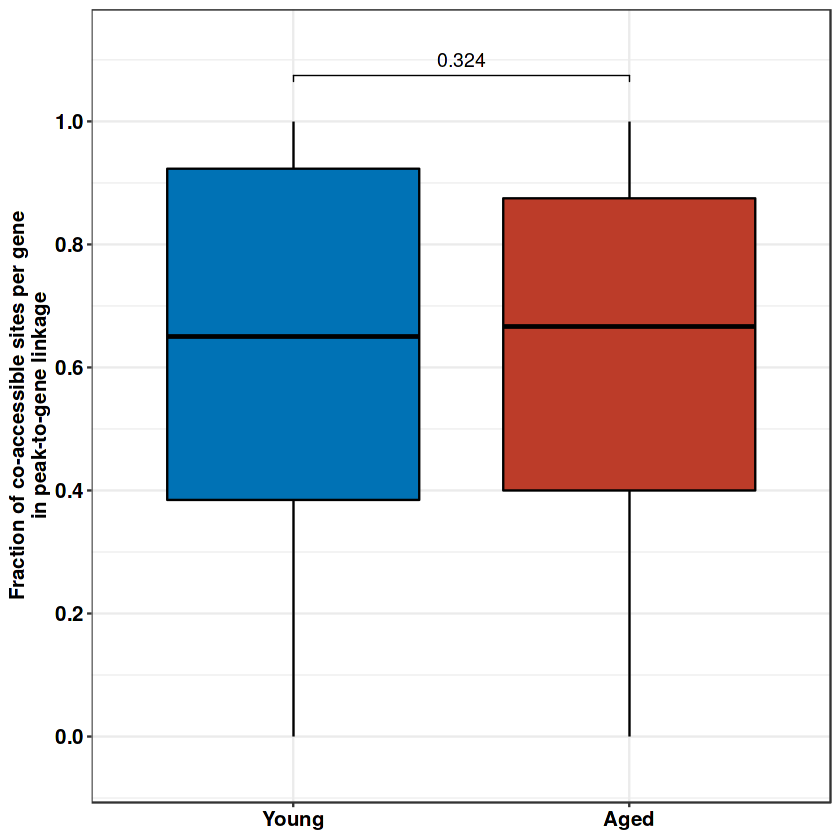

In [90]:
plt <- ggplot(p2g_conns_tbl_plt, aes(x=Age, y=frac)) +
    #geom_histogram(bins=10, position="dodge")
    geom_boxplot(aes(fill=Age), width=0.75, color="black") +
    scale_fill_manual(values=ggsci::pal_nejm()(2)[2:1]) +
    scale_x_discrete(labels=c("Young","Aged")) +
    scale_y_continuous(breaks=seq(0,1,0.2), expand=expansion(mult=c(0.1,0.1))) +
    stat_pvalue_manual(p2g_conns_tbl_plt_test, label="p.label", tip.length=0.01, label.size=4, bracket.nudge.y = 0.075) +
    theme_bw() + labs(x=NULL, y="Fraction of co-accessible sites per gene\nin peak-to-gene linkage") +
    theme(axis.text = element_text(size=12, face="bold", color="black"),
        axis.title = element_text(size=12, face="bold", color="black"),
        legend.position = "none")

png(file.path(projdir,"MuSC_subset","Cicero_plots","conns_per_p2g.png"), res=300, units='in', width=2.75, height=3.5)
print(plt)
dev.off()
plt

In [1079]:
mean(p2g_conns_tbl$young_frac); mean(p2g_conns_tbl$aged_frac)

[1] 0.5972405

[1] 0.6025648

In [477]:
p2g$kmeansId <- clustered_p2g$ATAC$kmeansId
p2g[p2g$gene=='Phf5a',]

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
"subscript is an array, passing it thru as.vector() first"


DataFrame with 6 rows and 9 columns
            idxATAC    idxRNA Correlation         FDR  VarQATAC   VarQRNA
          <integer> <integer>   <numeric>   <numeric> <numeric> <numeric>
P2G_21679     44645      7002    0.517722 1.65423e-42  0.991268  0.853958
P2G_21680     44667      7002    0.461435 5.66947e-33  0.929447  0.853958
P2G_21681     44678      7002    0.496074 1.25120e-38  0.911322  0.853958
P2G_21682     44696      7002    0.609171 2.06608e-62  0.871909  0.853958
P2G_21683     44697      7002    0.451230 1.99328e-31  0.478998  0.853958
P2G_21684     44699      7002    0.511499 2.30193e-41  0.995257  0.853958
                            peak    gene  kmeansId
                     <character> <array> <integer>
P2G_21679 chr15:81465979-81466..   Phf5a         5
P2G_21680 chr15:81856040-81856..   Phf5a         5
P2G_21681 chr15:81936517-81937..   Phf5a         4
P2G_21682 chr15:82135319-82135..   Phf5a         4
P2G_21683 chr15:82138478-82138..   Phf5a         5
P2G_21684 chr15

# Make GenomicInteractions objects

In [91]:
aged_conns_gi <- make_conns_gi(aged_conns)
young_conns_gi <- make_conns_gi(young_conns)
all_conns_gi <- make_conns_gi(all_conns)

In [92]:
saveRDS(aged_conns_gi, file.path(projdir, "MuSC_subset", "Cicero_objects", "aged_conns_gi.RDS"))
saveRDS(young_conns_gi, file.path(projdir, "MuSC_subset", "Cicero_objects", "young_conns_gi.RDS"))
saveRDS(all_conns_gi, file.path(projdir, "MuSC_subset", "Cicero_objects", "all_conns_gi.RDS"))

In [1516]:
all_conns_gi <- readRDS(file.path(projdir, "MuSC_subset", "Cicero_objects", "all_conns_gi.RDS"))

## Make distance between co-accessible sites violinplot

In [93]:
conns_dist <- data.frame(dist=c(aged_conns_gi$distance, young_conns_gi$distance, all_conns_gi$distance),
                         coaccess=c(aged_conns_gi$coaccess, young_conns_gi$coaccess, all_conns_gi$coaccess),
                         Age=c(rep_len("Aged", length(aged_conns_gi)),
                               rep_len("Young", length(young_conns_gi)),
                               rep_len("All", length(all_conns_gi))))

In [94]:
conns_dist_test <- conns_dist %>%
    dplyr::filter(coaccess>0.1) %>%
    wilcox_test(dist~Age)

png 
  2

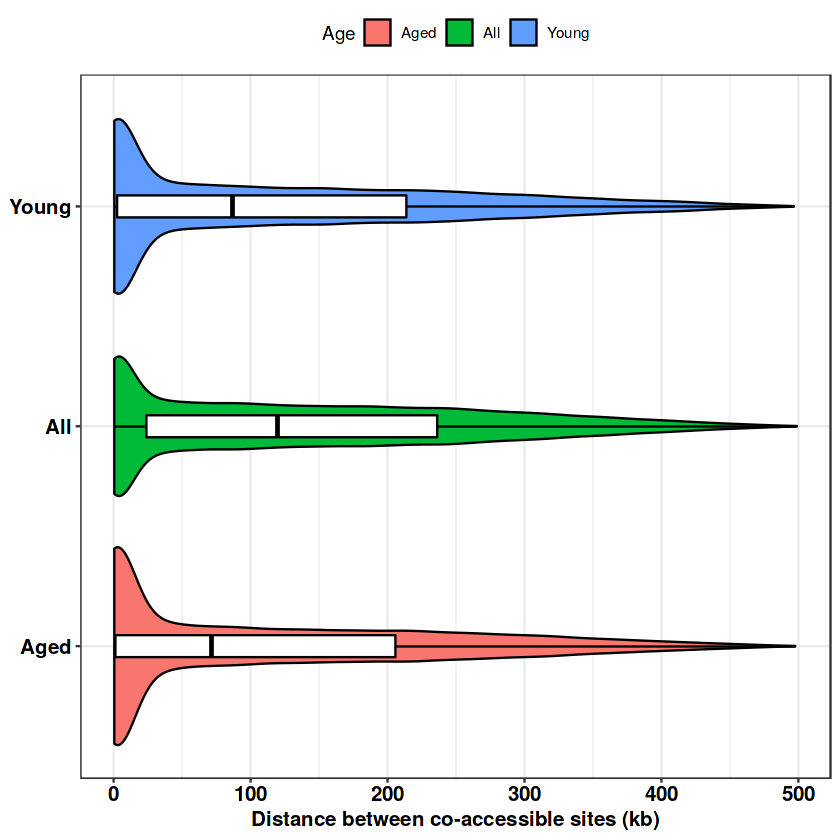

In [98]:
plt <- conns_dist %>%
    dplyr::filter(coaccess>0.1) %>%
    ggplot(aes(x=dist/1e3, y=Age)) + 
    geom_violin(aes(fill=Age), color="black") + 
    geom_boxplot(fill="white", color="black", width=0.1, outlier.size=NA) +
    #scale_fill_manual(values=ggsci::pal_nejm()(2)) +
    #stat_pvalue_manual(conns_dist_test) +
    labs(x="Distance between co-accessible sites (kb)", y=NULL) +
    theme_bw() +
    theme(axis.text=element_text(size=12, face="bold", color="black"),
        axis.title=element_text(size=12, face="bold", color="black"),
        legend.position="top") 
plt

png(file.path(projdir,"MuSC_subset", "Cicero_plots", "merged_conns_distance_violin.png"),res=300,units='in',width=4,height=4)
print(plt)
dev.off()

## Distance between co-accessible sites scatter plot

In [96]:
aged_conns_gi_subset <- aged_conns_gi[which(is.finite(aged_conns_gi$distance) & is.finite(aged_conns_gi$coaccess)), ]
aged_df <- getDensity(x=aged_conns_gi_subset$coaccess, y=aged_conns_gi_subset$distance, n=250, sample=NULL)

young_conns_gi_subset <- young_conns_gi[which(is.finite(young_conns_gi$distance) & is.finite(young_conns_gi$coaccess)), ]
young_df <- getDensity(x=young_conns_gi_subset$coaccess, y=young_conns_gi_subset$distance, n=250, sample=NULL)

all_conns_gi_subset <- all_conns_gi[which(is.finite(all_conns_gi$distance) & is.finite(all_conns_gi$coaccess)), ]
all_df <- getDensity(x=all_conns_gi_subset$coaccess, y=all_conns_gi_subset$distance, n=250, sample=NULL)

In [97]:
merged_df <- rbind(aged_df %>% mutate(Age = "Aged"),
                   young_df %>% mutate(Age = "Young"))
merged_df$Age <- factor(merged_df$Age, levels=c("Young","Aged"))

ERROR: Error in f(...): formal argument "res" matched by multiple actual arguments


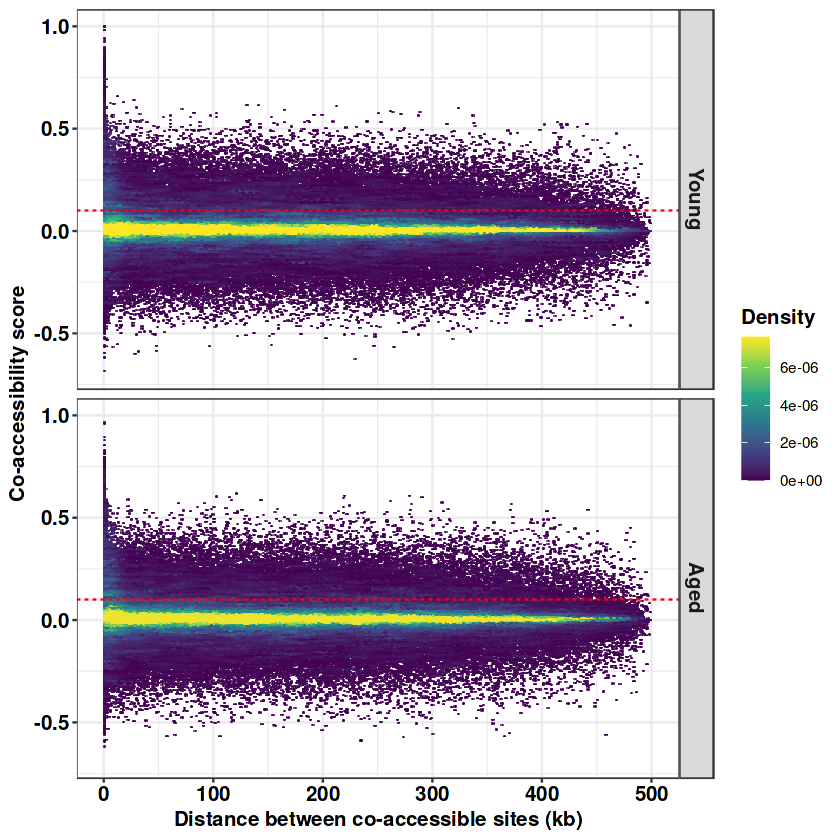

In [99]:
plt <- ggplot(merged_df, aes(x=y/1e3, y=x, color=Density)) +
    facet_grid(rows=vars(Age)) +
    scattermore::geom_scattermore(pointsize = 1) + 
    geom_hline(color = "red", yintercept = 0.1, lty=2) +
    scale_color_viridis_c() +
    theme_bw() +
    labs(x="Distance between co-accessible sites (kb)", y="Co-accessibility score") +
    theme(axis.text = element_text(color="black", size=12, face="bold"),
        axis.title = element_text(color="black", size=12, face="bold"),
        legend.title = element_text(size=12, face="bold"),
        strip.text = element_text(size=12, face="bold"))
plt

In [100]:
png(file.path(projdir,"MuSC_subset", "Cicero_plots", "conns_distance_scatter.png"),res=300,units='in',width=5,height=5)
print(plt)
dev.off()

png 
  2

In [101]:
saveRDS(merged_df, file.path(projdir, "MuSC_subset", "Cicero_objects", "merged_density_coaccess_dist.RDS"))

## Annotation of linked peaks

In [107]:
young_conns_gi <- add_link_annotation(young_conns_gi, 0)
aged_conns_gi <- add_link_annotation(aged_conns_gi, 0)
all_conns_gi <- add_link_annotation(all_conns_gi, 0)

>> preparing features information...		 2022-12-24 03:53:24 PM 
>> identifying nearest features...		 2022-12-24 03:53:24 PM 
>> calculating distance from peak to TSS...	 2022-12-24 03:53:28 PM 
>> assigning genomic annotation...		 2022-12-24 03:53:28 PM 
>> adding gene annotation...			 2022-12-24 03:53:46 PM 


Loading required package: org.Mm.eg.db



'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-12-24 03:53:47 PM 
>> done...					 2022-12-24 03:53:47 PM 
>> preparing features information...		 2022-12-24 03:53:47 PM 
>> identifying nearest features...		 2022-12-24 03:53:47 PM 
>> calculating distance from peak to TSS...	 2022-12-24 03:53:51 PM 
>> assigning genomic annotation...		 2022-12-24 03:53:51 PM 
>> adding gene annotation...			 2022-12-24 03:53:56 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-12-24 03:53:56 PM 
>> done...					 2022-12-24 03:53:56 PM 
>> preparing features information...		 2022-12-24 03:54:10 PM 
>> identifying nearest features...		 2022-12-24 03:54:10 PM 
>> calculating distance from peak to TSS...	 2022-12-24 03:54:14 PM 
>> assigning genomic annotation...		 2022-12-24 03:54:14 PM 
>> adding gene annotation...			 2022-12-24 03:54:18 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-12-24 03:54:19 PM 
>> done...					 2022-12-24 03:54:19 PM 
>> preparing features information...		 2022-12-24 03:54:19 PM 
>> identifying nearest features...		 2022-12-24 03:54:19 PM 
>> calculating distance from peak to TSS...	 2022-12-24 03:54:24 PM 
>> assigning genomic annotation...		 2022-12-24 03:54:24 PM 
>> adding gene annotation...			 2022-12-24 03:54:28 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-12-24 03:54:29 PM 
>> done...					 2022-12-24 03:54:29 PM 
>> preparing features information...		 2022-12-24 03:54:43 PM 
>> identifying nearest features...		 2022-12-24 03:54:43 PM 
>> calculating distance from peak to TSS...	 2022-12-24 03:54:47 PM 
>> assigning genomic annotation...		 2022-12-24 03:54:47 PM 
>> adding gene annotation...			 2022-12-24 03:54:53 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-12-24 03:54:54 PM 
>> done...					 2022-12-24 03:54:54 PM 
>> preparing features information...		 2022-12-24 03:54:54 PM 
>> identifying nearest features...		 2022-12-24 03:54:54 PM 
>> calculating distance from peak to TSS...	 2022-12-24 03:54:59 PM 
>> assigning genomic annotation...		 2022-12-24 03:54:59 PM 
>> adding gene annotation...			 2022-12-24 03:55:05 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-12-24 03:55:05 PM 
>> done...					 2022-12-24 03:55:05 PM 


In [108]:
saveRDS(aged_conns_gi, file.path(projdir,"MuSC_subset", "Cicero_objects","aged_conns_gi.RDS"))
saveRDS(young_conns_gi, file.path(projdir,"MuSC_subset", "Cicero_objects","young_conns_gi.RDS"))
saveRDS(all_conns_gi, file.path(projdir,"MuSC_subset", "Cicero_objects","all_conns_gi.RDS"))

In [109]:
link_anno_df <- rbind(mcols(young_conns_gi), mcols(aged_conns_gi)) %>%
  as.data.frame() %>% 
  mutate(Age = c(rep_len("Young",length(young_conns_gi)), rep_len("Aged",length(aged_conns_gi))))

In [125]:
link_anno_df_stats <- list()
for(i in seq(0,1,0.05)) {
  link_anno_df_stats[[as.character(i)]] <- link_anno_df %>% 
    dplyr::filter(coaccess>i) %>% 
    group_by(Age, link_anno) %>% 
    tally() %>%
    mutate(frac = n/sum(n))
}

Warning message:
"Removed 2 rows containing missing values (geom_point)."


png 
  2

Warning message:
"Removed 2 rows containing missing values (geom_point)."


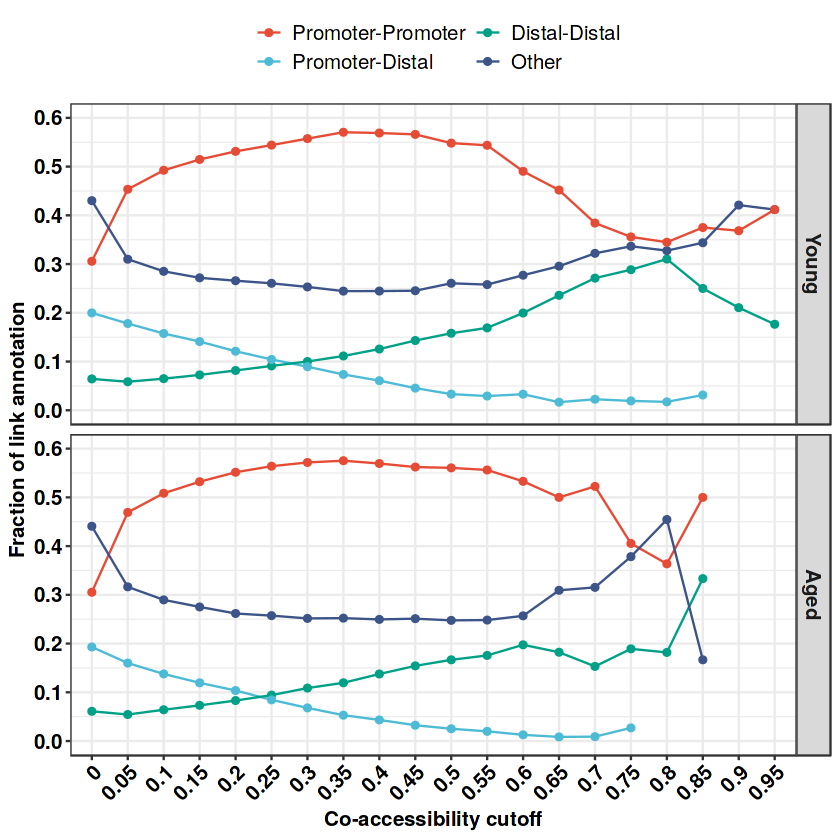

In [129]:
plt <- bind_rows(link_anno_df_stats, .id='id') %>%
  mutate(Age = factor(Age, levels=c("Young","Aged")),
         link_anno = factor(link_anno, levels=c("Promoter-Promoter","Promoter-Distal","Distal-Distal","Other"))) %>%
  ggplot(aes(x=id, y=frac, color=link_anno, group=link_anno)) +
  facet_grid(row=vars(Age)) +
  geom_path() +
  geom_point() +
  scale_y_continuous(breaks=seq(0,0.6,0.1), limits=c(0,0.6)) +
  scale_color_npg() +
  theme_bw() +
  guides(color = guide_legend(nrow=2)) +
  labs(x="Co-accessibility cutoff", y="Fraction of link annotation") +
  theme(axis.text.y = element_text(size=12, face="bold", color="black"),
        axis.text.x = element_text(size=12, face="bold", color="black", angle=45, hjust=1),
        axis.title = element_text(size=12, face="bold"),
        strip.text = element_text(size=12, face="bold"),
        legend.title = element_blank(),
        legend.text = element_text(size=12),
        legend.position = "top")

png(file.path(projdir, "MuSC_subset", "Cicero_plots", "cicero_links_anno_coaccess_cutoff.png"), res=300, units='in', width=6, height=5)
print(plt)
dev.off()
plt

`summarise()` has grouped output by 'Age'. You can override using the `.groups` argument.


png 
  2

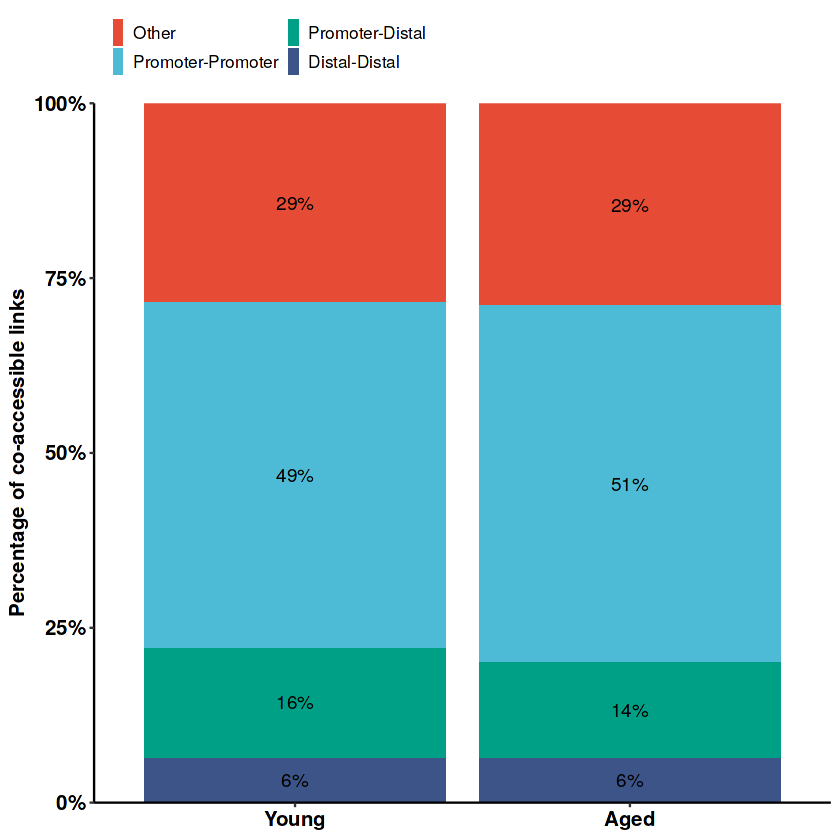

In [139]:
plt<- rbind(mcols(young_conns_gi), mcols(aged_conns_gi)) %>%
    as.data.frame() %>% 
    mutate(Age = c(rep_len("Young",length(young_conns_gi)), rep_len("Aged",length(aged_conns_gi)))) %>%
    dplyr::filter(coaccess>0.1) %>%
    group_by(Age, link_anno) %>%
    summarise(count = n()) %>%
    mutate(frac = count/sum(count),
         Age = factor(Age, levels=c("Young","Aged")),
         link_anno = factor(link_anno, levels=c("Other","Promoter-Promoter","Promoter-Distal","Distal-Distal"))) %>%
    ggplot(aes(x=Age, y=frac, fill=link_anno)) +
    geom_col() + 
    scale_fill_npg() +
    geom_text(aes(label=scales::percent(frac,accuracy=1)), 
            position=position_stack(vjust=0.5)) +
    theme_classic() + labs(x=NULL, y="Percentage of co-accessible links") +
    scale_y_continuous(labels = scales::percent, expand=expansion(mult=c(0,0))) +
    guides(fill = guide_legend(nrow=2)) +
    theme(axis.text.y = element_text(size=12, face="bold", color="black"),
        axis.text.x = element_text(size=12, face="bold", color="black"),
        axis.title = element_text(size=12, face="bold"),
        legend.title = element_blank(),
        legend.position = 'top', 
        legend.justification = c(0,1),
        legend.key.width = unit(0.25, 'cm'),
        legend.text = element_text(size=10))

png(file.path(projdir, "MuSC_subset", "Cicero_plots", "cicero_links_anno_barchart.png"), res=300, units='in', width=3.5, height=4.5)
print(plt)
dev.off()
plt

# Tally Cicero connections in TADs

In [141]:
summary(aged_conns_gi$distance)
summary(young_conns_gi$distance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    501   64948  154433  169511  257922  500412 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    501   65042  154421  169509  257859  500412 

**There are 2-3 outliers**

In [142]:
aged_conns_gi[aged_conns_gi$distance > 5e5,]
young_conns_gi[young_conns_gi$distance > 5e5,]

StrictGInteractions object with 3 interactions and 8 metadata columns:
      seqnames1             ranges1     seqnames2             ranges2 |
          <Rle>           <IRanges>         <Rle>           <IRanges> |
  [1]      chr4 126249579-126250079 ---      chr4 126749909-126750409 |
  [2]      chr7   48749531-48750031 ---      chr7   49249943-49250443 |
  [3]      chr8   84249518-84250018 ---      chr8   84749861-84750361 |
          coaccess  distance       idx Peak1_idx Peak2_idx  Peak1_anno
         <numeric> <integer> <integer> <numeric> <numeric> <character>
  [1]  0.00000e+00    500330    727157     33694     33725        None
  [2]  0.00000e+00    500412    989119     45366     45389        None
  [3] -5.67249e-06    500343   1081387     48933     48973        None
       Peak2_anno   link_anno
      <character> <character>
  [1]        None       Other
  [2]        None       Other
  [3]        None       Other
  -------
  regions: 54217 ranges and 0 metadata columns
  seqin

StrictGInteractions object with 2 interactions and 8 metadata columns:
      seqnames1             ranges1     seqnames2             ranges2 |
          <Rle>           <IRanges>         <Rle>           <IRanges> |
  [1]      chr4 126249579-126250079 ---      chr4 126749909-126750409 |
  [2]      chr7   48749531-48750031 ---      chr7   49249943-49250443 |
       coaccess  distance       idx Peak1_idx Peak2_idx  Peak1_anno  Peak2_anno
      <numeric> <integer> <integer> <numeric> <numeric> <character> <character>
  [1]         0    500330    674983     32403     32433        None        None
  [2]         0    500412    919975     43649     43670        None        None
        link_anno
      <character>
  [1]       Other
  [2]       Other
  -------
  regions: 52199 ranges and 0 metadata columns
  seqinfo: 20 sequences from an unspecified genome; no seqlengths

In [143]:
aged_conns_gi$distance_bin <- cut((aged_conns_gi$distance)/1e3, breaks=seq(0,5e5,by=2.5e4)/1e3, ordered_result=T)
young_conns_gi$distance_bin <- cut((young_conns_gi$distance)/1e3, breaks=seq(0,5e5,by=2.5e4)/1e3, ordered_result=T)

In [15]:
aged_conns_gi_a1 <- add_conns_TAD(aged_conns_gi, "first", aged.domain.ranges)
aged_conns_gi_a2 <- add_conns_TAD(aged_conns_gi, "second", aged.domain.ranges)
young_conns_gi_a1 <- add_conns_TAD(young_conns_gi, "first", young.domain.ranges)
young_conns_gi_a2 <- add_conns_TAD(young_conns_gi, "second", young.domain.ranges)

In [16]:
aged_conns_gi <- tally_TADs_per_anchor(aged_conns_gi, aged_conns_gi_a1, aged_conns_gi_a2)
young_conns_gi <- tally_TADs_per_anchor(young_conns_gi, young_conns_gi_a1, young_conns_gi_a2)

In [17]:
table(young_conns_gi$same_TAD)
table(aged_conns_gi$same_TAD)


 FALSE   TRUE 
262250 813366 


 FALSE   TRUE 
263674 893365 

In [18]:
saveRDS(aged_conns_gi, file.path(projdir, "MuSC_subset", "Cicero_objects", "aged_conns_gi.RDS"))
saveRDS(young_conns_gi, file.path(projdir, "MuSC_subset", "Cicero_objects", "young_conns_gi.RDS"))

In [28]:
aged_conns_gi <- readRDS(file.path(projdir, "MuSC_subset", "Cicero_objects", "aged_conns_gi.RDS"))
young_conns_gi <- readRDS(file.path(projdir, "MuSC_subset", "Cicero_objects", "young_conns_gi.RDS"))

# Calculate fold-enrichment of Cicero connections in TADs

In [15]:
thresh_range <- seq(0.05,0.25,by=0.05)

bins <- na.omit(levels(aged_conns_gi$distance_bin))
aged_ratio <- calculate_intra_tad_ratio(thresh_range, bins, aged_conns_gi)

bins <- na.omit(levels(young_conns_gi$distance_bin))
young_ratio <- calculate_intra_tad_ratio(thresh_range, bins, young_conns_gi)

In [16]:
merged_ratio <- rbind(aged_ratio %>% mutate(Age="Aged"),
                      young_ratio %>% mutate(Age="Young"))

In [19]:
plt_label_idx <- c(1,5,10,15,20)
merged_ratio_plt_labels <- rep("",length(levels(merged_ratio$distance_bins)))
merged_ratio_plt_labels[plt_label_idx] <- levels(merged_ratio$distance_bins)[plt_label_idx]

`geom_smooth()` using formula 'y ~ x'



png 
  2

`geom_smooth()` using formula 'y ~ x'



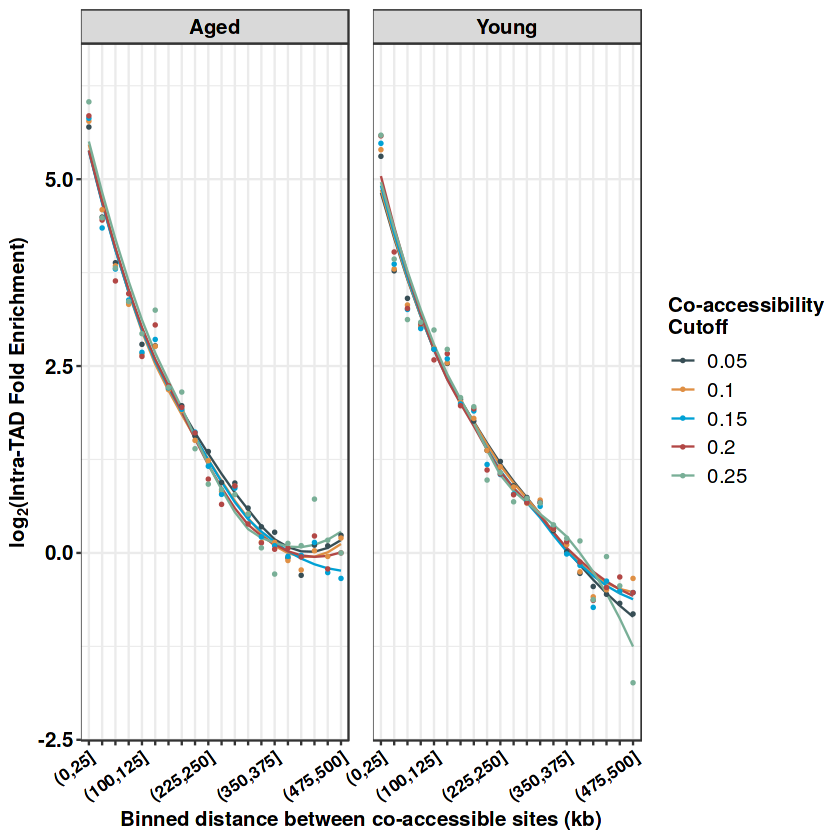

In [271]:
plt <- merged_ratio %>%
    mutate(Coaccess = sapply(Coaccess, function(x) unlist(strsplit(x,split="_",fixed=T))[2])) %>%
    ggplot(aes(x=distance_bins, y=log2(ratio))) +
    facet_wrap(~Age) +
    stat_smooth(aes(group=Coaccess, color=Coaccess), method = "loess", se=FALSE, size=0.5) +
    #geom_path(aes(group=Coaccess, color=Coaccess)) +
    geom_point(aes(color=Coaccess), size=0.5) +
    scale_color_jama() +
    scale_x_discrete(labels=merged_ratio_plt_labels) +
    theme_bw() + 
    scale_y_continuous(expand = expansion(mult=c(0.1,0.1))) +
    guides(color=guide_legend(title="Co-accessibility\nCutoff")) +
    labs(x="Binned distance between co-accessible sites (kb)", y=expression(bold(paste("lo","g"["2"],"(Intra-TAD Fold Enrichment)")))) +
    theme(axis.text.x = element_text(size=10, face="bold", color="black", angle=35, hjust=1),
          axis.text.y = element_text(size=12, face="bold", color="black"),
          axis.title = element_text(size=12, face="bold", color="black"),
          strip.text = element_text(size=12, face="bold", color="black"),
          legend.title = element_text(size=12, color="black", face="bold"),
          legend.text = element_text(size=12, color="black"),
          panel.spacing=unit(1,"lines"))

png(file.path(projdir, "MuSC_subset", "Cicero_plots", "merged_conns_intra_tad_enrichment_spline.png"), res=300, units='in', width=6.5, height=3.5)
print(plt)
dev.off()
plt

## Permute connections to get background for intra-TAD enrichment

**FOREACH HOLDS ON TO MEMORY AFTER EACH RUN, WILL NEED TO RESTART KERNEL TO RELEASE IT** 

In [28]:
shuffled_ratio_mat_permute_aged <- permute_conns(aged_conns_gi, aged.domain.ranges, seq(0.05,0.25,0.05), n_perm=500, n_cores=60)

In [29]:
saveRDS(shuffled_ratio_mat_permute_aged, file.path(projdir, "MuSC_subset", "shuffled_ratio_mat_permute_aged.RDS"))

In [12]:
shuffled_ratio_mat_permute_aged

thresh,distance_bin,ratio,replicate
<chr>,<chr>,<dbl>,<int>
0.05,"(0,25]",0.03730646,1
0.05,"(25,50]",0.09478279,1
0.05,"(50,75]",0.09744332,1
0.05,"(75,100]",0.10505051,1
0.05,"(100,125]",0.09754706,1
0.05,"(125,150]",0.09235844,1
0.05,"(150,175]",0.10819071,1
0.05,"(175,200]",0.10152439,1
0.05,"(200,225]",0.09733416,1


In [6]:
shuffled_ratio_mat_permute_young <- permute_conns(young_conns_gi, young.domain.ranges, seq(0.05,0.25,0.05), n_perm=500, n_cores=60)

In [9]:
saveRDS(shuffled_ratio_mat_permute_young, file.path(projdir, "MuSC_subset", "shuffled_ratio_mat_permute_young.RDS"))

In [8]:
shuffled_ratio_mat_permute_young

thresh,distance_bin,ratio,replicate
<chr>,<chr>,<dbl>,<int>
0.05,"(0,25]",0.04057200,1
0.05,"(25,50]",0.09054025,1
0.05,"(50,75]",0.10046105,1
0.05,"(75,100]",0.10348234,1
0.05,"(100,125]",0.09555189,1
0.05,"(125,150]",0.08621652,1
0.05,"(150,175]",0.08361678,1
0.05,"(175,200]",0.08693046,1
0.05,"(200,225]",0.08726708,1


In [10]:
shuffled_ratio_mat_permute_aged <- readRDS(file.path(projdir, "MuSC_subset", "shuffled_ratio_mat_permute_aged.RDS"))
shuffled_ratio_mat_permute_young <- readRDS(file.path(projdir, "MuSC_subset", "shuffled_ratio_mat_permute_young.RDS"))

## Make actual and permuted connection plot

### Merge actual and permuted data

In [21]:
str(merged_ratio)

tibble [200 × 4] (S3: tbl_df/tbl/data.frame)
 $ Coaccess     : chr [1:200] "thresh_0.05" "thresh_0.05" "thresh_0.05" "thresh_0.05" ...
 $ distance_bins: Factor w/ 20 levels "(0,25]","(25,50]",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ ratio        : num [1:200] 51.89 22.51 14.74 10.22 6.92 ...
 $ Age          : chr [1:200] "Aged" "Aged" "Aged" "Aged" ...


In [13]:
permuted_data <- rbind(shuffled_ratio_mat_permute_young %>% mutate(Age = 'Young'),
                       shuffled_ratio_mat_permute_aged %>% mutate(Age = 'Aged'))
colnames(permuted_data) <- c('Coaccess','distance_bins','ratio','replicate','Age')
permuted_data$Coaccess <- paste0("thresh_",permuted_data$Coaccess)
permuted_data

Coaccess,distance_bins,ratio,replicate,Age
<chr>,<chr>,<dbl>,<int>,<chr>
thresh_0.05,"(0,25]",0.04057200,1,Young
thresh_0.05,"(25,50]",0.09054025,1,Young
thresh_0.05,"(50,75]",0.10046105,1,Young
thresh_0.05,"(75,100]",0.10348234,1,Young
thresh_0.05,"(100,125]",0.09555189,1,Young
thresh_0.05,"(125,150]",0.08621652,1,Young
thresh_0.05,"(150,175]",0.08361678,1,Young
thresh_0.05,"(175,200]",0.08693046,1,Young
thresh_0.05,"(200,225]",0.08726708,1,Young


In [27]:
intra_tad_ratio_w_shuffle <- rbind(merged_ratio %>% mutate(replicate = 'Real') %>% dplyr::select(Coaccess, distance_bins, ratio, replicate, Age),
                                   permuted_data)
intra_tad_ratio_w_shuffle$Age <- factor(intra_tad_ratio_w_shuffle$Age, levels=c('Young','Aged'))

intra_tad_ratio_w_shuffle$lty_group <- 'Shuffled'
intra_tad_ratio_w_shuffle$lty_group[intra_tad_ratio_w_shuffle$replicate=='Real'] <- 'Real'
intra_tad_ratio_w_shuffle$lty_group <- factor(intra_tad_ratio_w_shuffle$lty_group, levels=c("Real","Shuffled"))

intra_tad_ratio_w_shuffle <- mutate(intra_tad_ratio_w_shuffle, group = paste(Coaccess, Age, lty_group, sep="_"))

intra_tad_ratio_w_shuffle$Coaccess <- gsub("thresh_","",intra_tad_ratio_w_shuffle$Coaccess,fixed=TRUE)

intra_tad_ratio_w_shuffle

Coaccess,distance_bins,ratio,replicate,Age,lty_group,group
<chr>,<fct>,<dbl>,<chr>,<fct>,<fct>,<chr>
0.05,"(0,25]",51.8922306,Real,Aged,Real,thresh_0.05_Aged_Real
0.05,"(25,50]",22.5133929,Real,Aged,Real,thresh_0.05_Aged_Real
0.05,"(50,75]",14.7439446,Real,Aged,Real,thresh_0.05_Aged_Real
0.05,"(75,100]",10.2205128,Real,Aged,Real,thresh_0.05_Aged_Real
0.05,"(100,125]",6.9176955,Real,Aged,Real,thresh_0.05_Aged_Real
0.05,"(125,150]",6.8228346,Real,Aged,Real,thresh_0.05_Aged_Real
0.05,"(150,175]",4.5870570,Real,Aged,Real,thresh_0.05_Aged_Real
0.05,"(175,200]",3.9156463,Real,Aged,Real,thresh_0.05_Aged_Real
0.05,"(200,225]",2.9553073,Real,Aged,Real,thresh_0.05_Aged_Real


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



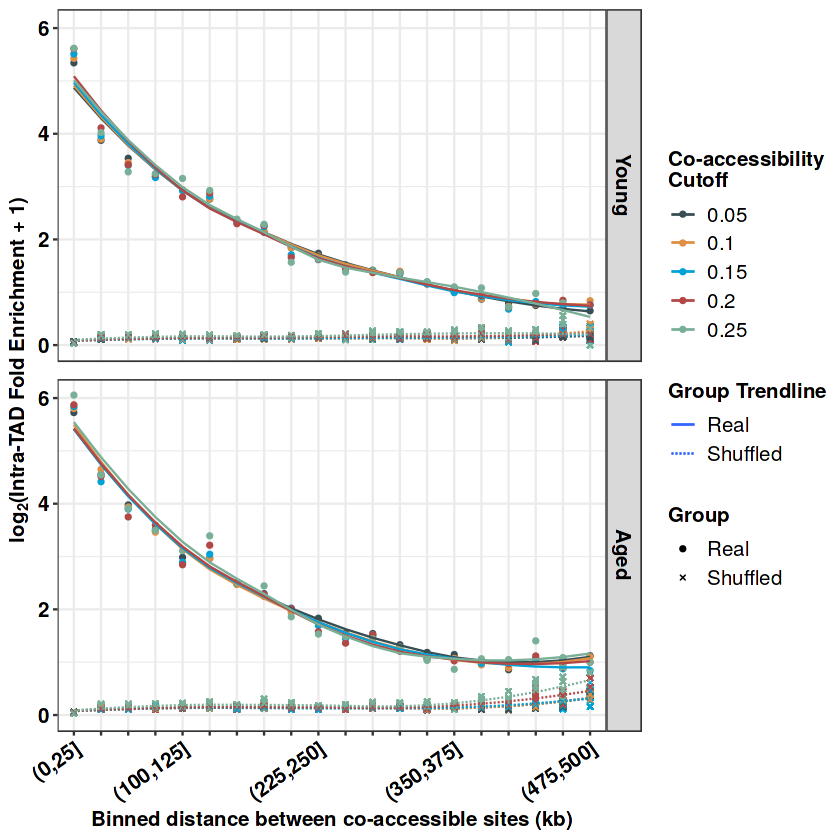

In [30]:
plt <- ggplot(intra_tad_ratio_w_shuffle, aes(x=distance_bins, y=log2(ratio+1))) +
    facet_grid(rows=vars(Age)) +
    geom_point(aes(color=Coaccess, shape=lty_group), size=1) +
    stat_smooth(data = intra_tad_ratio_w_shuffle %>% dplyr::filter(lty_group=="Real"),
              aes(color=Coaccess, group=group, lty=lty_group), method="loess", size=0.5, se=F) +
    stat_smooth(data = intra_tad_ratio_w_shuffle %>% dplyr::filter(lty_group=="Shuffled"),
              aes(color=Coaccess, group=group, lty=lty_group), method="loess", size=0.5, se=F) +
    #geom_path(aes(color=Coaccess, group=group), size=0.5) +
    scale_color_jama() +
    scale_shape_manual(values=c(19, 4)) + 
    scale_x_discrete(labels=merged_ratio_plt_labels) +
    theme_bw() + 
    guides(color=guide_legend(title="Co-accessibility\nCutoff"),
           shape=guide_legend(title="Group"),
           lty=guide_legend(title="Group Trendline")) +
    labs(x="Binned distance between co-accessible sites (kb)", y=expression(bold(paste("lo","g"["2"],"(Intra-TAD Fold Enrichment + 1)")))) +
    theme(axis.text.x = element_text(size=12, face="bold", color="black", angle=35, hjust=1),
        axis.text.y = element_text(size=12, face="bold", color="black"),
        axis.title = element_text(size=12, face="bold", color="black"),
        strip.text = element_text(size=12, face="bold", color="black"),
        legend.title = element_text(size=12, color="black", face="bold"),
        legend.text = element_text(size=12, color="black"),
        panel.spacing = unit(0.75, "lines"))
plt

In [31]:
png(file.path(projdir, "MuSC_subset", "Cicero_plots", "merged_conns_intra_tad_enrichment_spline.png"), res=300, units='in', width=5.5, height=5)
print(plt)
dev.off()

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



png 
  2

# Compare CCAN properties at different cutoffs

In [1461]:
all_young_peak_anno <- rbind(as.data.frame(anchorOne(young_conns_gi)),
                             as.data.frame(anchorTwo(young_conns_gi)))
all_young_peak_anno$peak_anno <- c(mcols(young_conns_gi)$Peak1_anno, mcols(young_conns_gi)$Peak2_anno)
all_young_peak_anno <- all_young_peak_anno %>% mutate(peakstring = paste(seqnames, start, end, sep="_"))

all_aged_peak_anno <- rbind(as.data.frame(anchorOne(aged_conns_gi)),
                            as.data.frame(anchorTwo(aged_conns_gi)))
all_aged_peak_anno$peak_anno <- c(mcols(aged_conns_gi)$Peak1_anno, mcols(aged_conns_gi)$Peak2_anno)
all_aged_peak_anno <- all_aged_peak_anno %>% mutate(peakstring = paste(seqnames, start, end, sep="_"))

## Get CCANs at each cutoff

In [1460]:
cutoffs <- seq(0,0.5,by=0.05)

aged_ccan_list <- lapply(cutoffs, function(x) generate_ccans(aged_conns, coaccess_cutoff_override = x))
names(aged_ccan_list) <- cutoffs

young_ccan_list <- lapply(cutoffs, function(x) generate_ccans(young_conns, coaccess_cutoff_override = x))
names(young_ccan_list) <- cutoffs

[1] "Coaccessibility cutoff used: 0"
[1] "Coaccessibility cutoff used: 0.05"
[1] "Coaccessibility cutoff used: 0.1"
[1] "Coaccessibility cutoff used: 0.15"
[1] "Coaccessibility cutoff used: 0.2"
[1] "Coaccessibility cutoff used: 0.25"
[1] "Coaccessibility cutoff used: 0.3"
[1] "Coaccessibility cutoff used: 0.35"
[1] "Coaccessibility cutoff used: 0.4"
[1] "Coaccessibility cutoff used: 0.45"
[1] "Coaccessibility cutoff used: 0.5"
[1] "Coaccessibility cutoff used: 0"
[1] "Coaccessibility cutoff used: 0.05"
[1] "Coaccessibility cutoff used: 0.1"
[1] "Coaccessibility cutoff used: 0.15"
[1] "Coaccessibility cutoff used: 0.2"
[1] "Coaccessibility cutoff used: 0.25"
[1] "Coaccessibility cutoff used: 0.3"
[1] "Coaccessibility cutoff used: 0.35"
[1] "Coaccessibility cutoff used: 0.4"
[1] "Coaccessibility cutoff used: 0.45"
[1] "Coaccessibility cutoff used: 0.5"


In [1462]:
ccan_cutoff_df <- rbind(bind_rows(aged_ccan_list, .id='id') %>% mutate(Age="Aged", 
                                                                      peak_anno = all_aged_peak_anno$peak_anno[match(Peak,all_aged_peak_anno$peakstring)]),
                       bind_rows(young_ccan_list, .id='id') %>% mutate(Age="Young",
                                                                       peak_anno = all_young_peak_anno$peak_anno[match(Peak,all_young_peak_anno$peakstring)]))
ccan_cutoff_df$Age <- factor(ccan_cutoff_df$Age, levels=c("Young","Aged"))

In [1463]:
ccan_cutoff_lbl <- rep("", length(unique(ccan_cutoff_df$id)))
ccan_cutoff_lbl[seq(1,length(unique(ccan_cutoff_df$id)),2)] <- unique(ccan_cutoff_df$id)[seq(1,length(unique(ccan_cutoff_df$id)),2)]

## Number of CCANs at each cutoff

In [1606]:
ccan_cutoff_df$CCAN[ccan_cutoff_df$Age=="Aged" & ccan_cutoff_df$id==0.1]

[1]    2    2    2    3    3    3    3    5    5    5   11   11   11   11
   [15]   11   11   11   11   11   11   11   11   11   11   12   11   11   11
   [29]   11   12   12   18   18   18   18   18   18   18   18   18   18   23
   [43]   23   23   26   26   26   29   29   29   31   31   31   32   31   32
   [57]   32   32   32   32   33   33   33   35   35   35   35   35   35   35
   [71]   40   41   41   41   41   41   41   41   41   41   41   41   41   41
   [85]   41   41   41   41   41   41   41   41   41   41   41   41   41   41
   [99]   41   41   41   41   41   41   41   41   41   41   41   41   41   41
  [113]   41   41   41   41   41   41   41   41   41   41   41   41   41   41
  [127]   41   41   41   41   41   41   41   41   41   41   41   41   41   41
  [141]   41   41   41   41   41   41   41   41   41   41   41   41   41   41
  [155]   41   41   41   41   41   41   41   41   41   41   41   41   41   41
  [169]   41   41   41   41   41   41   40   44   44   44   44   44   44   44
  [183]   44   44   44   44   44   44   44   44   44   44   44   44   44   40
  [197]   44   44   44   44   44   44   44   44   44   44   44   44   44   44
  [211]   44   44   44   44   44   44   44   44   44   44   44   44   44   44
  [225]   44   44   44   44   44   44   44   44   44   44   44   44   44   44
  [239]   44   44   44   44   46   44   44   46   44   40   46   44   44   44
  [253]   44   44   44   44   44   44   44   40   44   44   44   44   44   44
  [267]   44   44   44   44   44   44   44   44   44   44   44   44   44   44
  [281]   44   44   44   44   44   44   40   40   40   49   49   49   49   49
  [295]   49   49   49   49   49   49   49   49   49   49   51   51   51   49
  [309]   49   53   53   54   53   53   54   54   54   54   54   54   57   57
  [323]   57   57   57   58   58   58   58   60   60   60   60   60   64   64
  [337]   64   64   64   64   64   64   64   64   64   67   67   67   67   68
  [351]   68   68   69   69   69   69   73   73   73   73   76   76   76   78
  [365]   78   78   78   81   81   81   81   81   81   81   81   81   81   81
  [379]   81   81   81   84   84   84   85   85   85   85   85   85   85   85
  [393]   85   87   87   87   87   89   89   89   90   90   90   91   91   94
  [407]   94   94   94   94   91   94   94   94   95   98   99   99   98   98
  [421]   98   98   98   98   98   99   99   98   98   98   98   98   98   98
  [435]   98   98   98   98   98   98   98   98   98   98   98   98   95   95
  [449]   95   98   98   98   98   98   98   98   98   98   98   98   98   98
  [463]   98   98   98   95   95   98   98   98   95   95  103  103  103   95
  [477]  109  109  109  110  110  110  114  115  115  115  114  114  114  114
  [491]  116  116  114  116  116  116  118  118  118  120  120  120  123  123
  [505]  123  123  123  123  123  123  123  123  123  123  123  123  123  123
  [519]  123  123  123  123  123  123  123  123  123  123  123  123  123  123
  [533]  123  123  123  123  123  123  123  130  130  130  130  130  130  130
  [547]  130  130  130  130  131  130  130  130  130  130  130  131  130  130
  [561]  130  131  131  130  130  130  130  130  130  130  130  130  130  130
  [575]  130  130  130  130  130  130  130  130  130  130  130  130  130  130
  [589]  130  133  130  130  130  130  130  130  130  130  130  133  133  130
  [603]  130  130  130  130  130  130  137  138  138  139  138  138  137  139
  [617]  137  140  140  140  140  140  140  140  140  140  139  140  140  142
  [631]  142  142  142  142  144  144  144  144  144  144  144  144  142  142
  [645]  142  142  146  147  147  147  146  146  147  146  146  147  153  153
  [659]  153  153  156  156  156  156  156  156  156  156  156  158  158  158
  [673]  162  162  162  162  162  162  162  162  162  162  162  162  162  162
  [687]  162  162  162  162  162  162  162  162  162  162  162  162  162  165
  [701]  162  162  166  165  162  167  165  165  162  167  167  162  169  170
  [715]  169  170  170  17

`summarise()` has grouped output by 'Age'. You can override using the `.groups` argument.


png 
  2

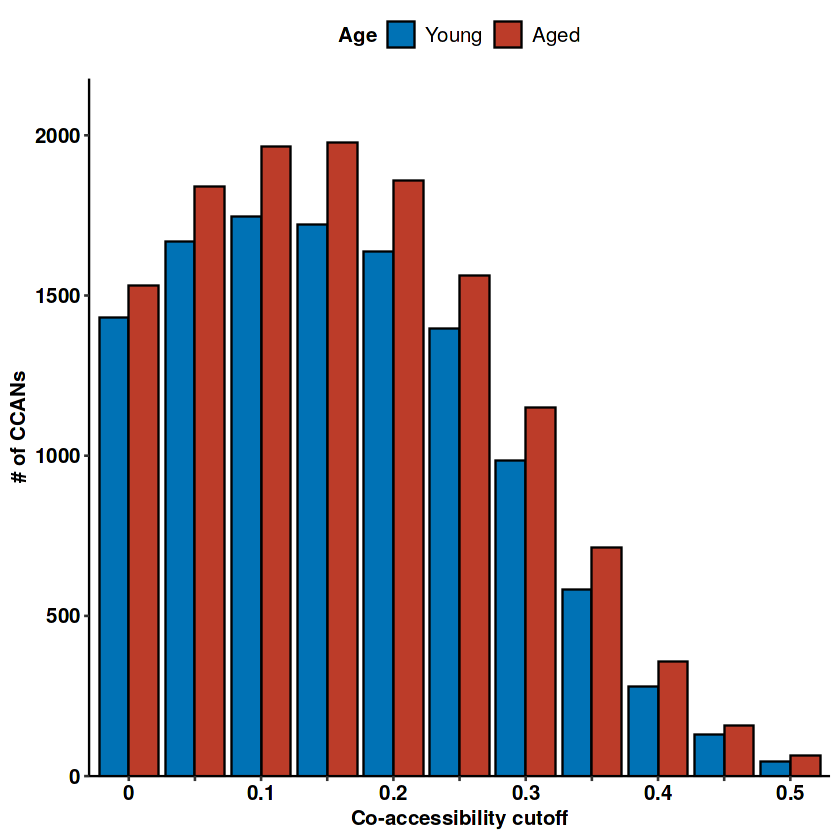

In [37]:
plt <- ccan_cutoff_df %>% 
    group_by(Age, id) %>%
    summarise(num_CCAN = n_distinct(CCAN)) %>%
    ggplot(aes(x=id, y=num_CCAN)) + geom_col(aes(fill=Age), color="black", position="dodge") +
    theme_pubr() + 
    scale_x_discrete(labels=ccan_cutoff_lbl) +
    scale_y_continuous(expand=expansion(mult=c(0,0.1))) +
    labs(x="Co-accessibility cutoff", y="# of CCANs") +
    scale_fill_manual(values=pal_nejm()(2)[2:1]) +
    theme(legend.text = element_text(size=12),
        legend.title = element_text(face="bold"),
        axis.text = element_text(face="bold"),
        axis.title = element_text(face="bold"))
plt

png(file.path(projdir,"MuSC_subset","Cicero_plots","CCAN_cutoff_number.png"), res=300, units='in', width=4, height=3)
print(plt)
dev.off()

## Size of CCANs at each cutoff

`summarise()` has grouped output by 'Age', 'id'. You can override using the `.groups` argument.


png 
  2

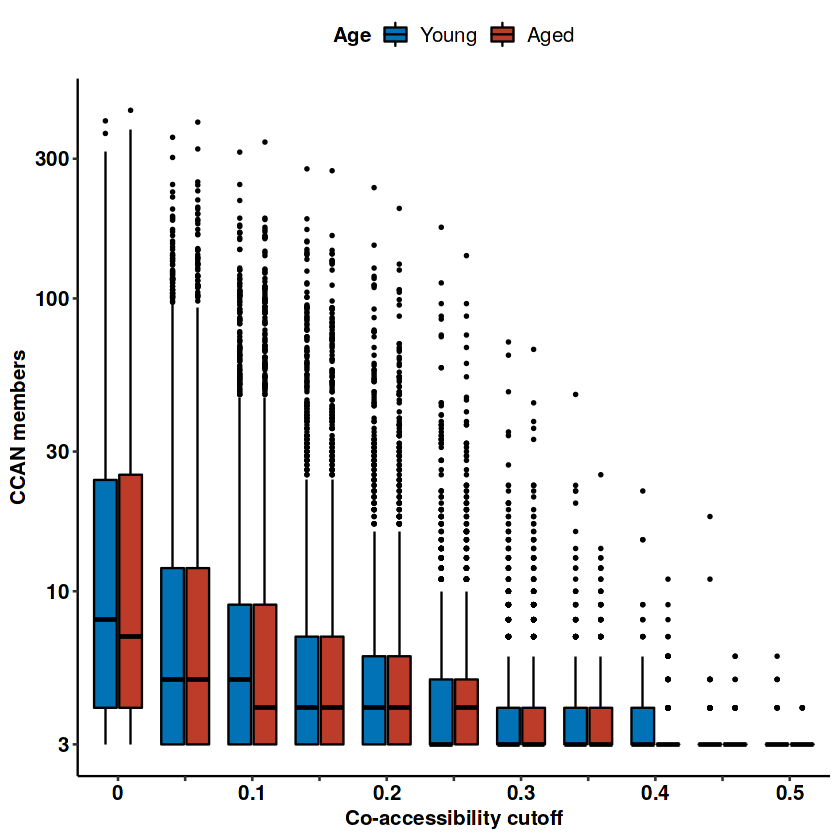

In [40]:
plt <- ccan_cutoff_df %>% 
    group_by(Age, id, CCAN) %>%
    summarise(CCAN_size = n()) %>%
    ggplot(aes(x=id, y=CCAN_size)) + geom_boxplot(aes(fill=Age), color="black", outlier.size=0.5) +
    scale_y_log10() +
    theme_pubr() +
    scale_x_discrete(labels=ccan_cutoff_lbl) +
    labs(x="Co-accessibility cutoff", y="CCAN members") +
    scale_fill_manual(values=pal_nejm()(2)[2:1]) +
    theme(legend.text = element_text(size=12),
        legend.title = element_text(face="bold"),
        axis.text = element_text(face="bold"),
        axis.title = element_text(face="bold"))
plt

png(file.path(projdir,"MuSC_subset","Cicero_plots","CCAN_cutoff_size.png"), res=300, units='in', width=4, height=3)
print(plt)
dev.off()

## Number of promoters in each CCAN at each cutoff

`summarise()` has grouped output by 'Age', 'id'. You can override using the `.groups` argument.


png 
  2

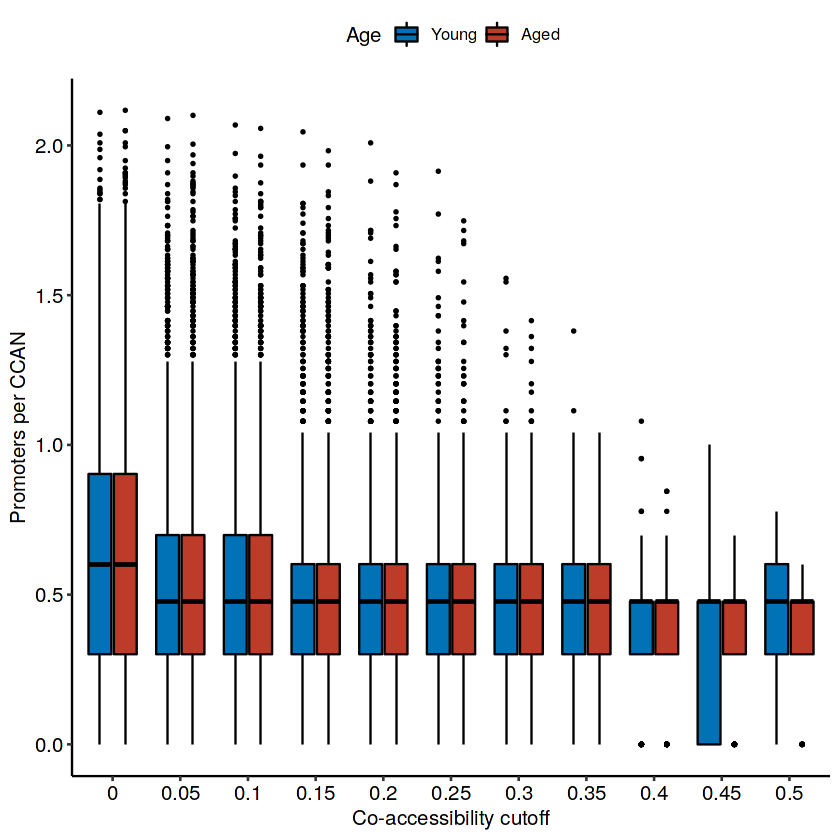

In [43]:
plt <- ccan_cutoff_df %>% 
    group_by(Age, id, CCAN) %>%
    summarise(num_promoter = sum(peak_anno=="Promoter")) %>%
    ggplot(aes(x=id, y=log10(num_promoter+1))) + geom_boxplot(aes(fill=Age), color="black", outlier.size=0.5) +
    theme_pubr() +
    labs(x="Co-accessibility cutoff", y="Promoters per CCAN") +
    scale_fill_manual(values=pal_nejm()(2)[2:1])
plt

png(file.path(projdir,"MuSC_subset","Cicero_plots","CCAN_cutoff_promoters.png"), res=300, units='in', width=4, height=3)
print(plt)
dev.off()

# Get lists of max-matched CCANs

In [13]:
# Generate lists of CCANs using the same co-accessibility threshold
aged_ccans <- generate_ccans(aged_conns, coaccess_cutoff_override = 0.1)
young_ccans <- generate_ccans(young_conns, coaccess_cutoff_override = 0.1)
all_ccans <- generate_ccans(all_conns, coaccess_cutoff_override = 0.1)

[1] "Coaccessibility cutoff used: 0.1"
[1] "Coaccessibility cutoff used: 0.1"
[1] "Coaccessibility cutoff used: 0.1"


In [1590]:
aged_ccans %>% group_by(CCAN) %>% summarise(num_peak = n_distinct(Peak)) %>% pull(num_peak) %>% summary()
young_ccans %>% group_by(CCAN) %>% summarise(num_peak = n_distinct(Peak)) %>% pull(num_peak) %>% summary()
all_ccans %>% group_by(CCAN) %>% summarise(num_peak = n_distinct(Peak)) %>% pull(num_peak) %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.00    3.00    4.00   11.42    9.00  342.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.00    3.00    5.00   12.03    9.00  316.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.00    3.00    5.00   13.17   10.00  296.00 

## Run max-matching algorithm

In [14]:
maxmatched_CCAN <- find_best_ccan_match(aged_ccans, young_ccans)
colnames(maxmatched_CCAN) <- c("Aged", "Young")
dim(maxmatched_CCAN)
dim(aged_ccans)
dim(young_ccans)

Aggregation function missing: defaulting to length



[1] 1174    2

[1] 22448     2

[1] 21025     2

In [1611]:
aged_ccans

,Peak,CCAN
,<chr>,<dbl>
chr10_100486660_100487160,chr10_100486660_100487160,2
chr10_100487163_100487663,chr10_100487163_100487663,2
chr10_100589009_100589509,chr10_100589009_100589509,2
chr10_105572764_105573264,chr10_105572764_105573264,3
chr10_105573433_105573933,chr10_105573433_105573933,3
chr10_105574251_105574751,chr10_105574251_105574751,3
chr10_105575150_105575650,chr10_105575150_105575650,3
chr10_107122110_107122610,chr10_107122110_107122610,5
chr10_107123016_107123516,chr10_107123016_107123516,5


In [1614]:
length(unique(aged_ccans$CCAN)); nrow(maxmatched_CCAN)

[1] 1965

[1] 1173

In [71]:
all_maxmatched_CCAN_young <- find_best_ccan_match(all_ccans, young_ccans)
colnames(all_maxmatched_CCAN_young) <- c("All", "Young")

all_maxmatched_CCAN_aged <- find_best_ccan_match(all_ccans, aged_ccans)
colnames(all_maxmatched_CCAN_aged) <- c("All", "Aged")

Aggregation function missing: defaulting to length

Aggregation function missing: defaulting to length



## How many sites in the original CCANs are captured by matched CCANs?

In [72]:
matched_aged_peaks <- unique(aged_ccans[aged_ccans$CCAN %in% maxmatched_CCAN[,'Aged'],]$Peak)
matched_young_peaks <- unique(young_ccans[young_ccans$CCAN %in% maxmatched_CCAN[,'Young'],]$Peak)

length(matched_young_peaks) / dim(young_ccans)[1]
length(matched_aged_peaks) / dim(aged_ccans)[1]

[1] 0.8833769

[1] 0.8518354

## How many peaks are shared between young and aged in matched CCANs?

In [73]:
maxmatched_CCAN_stats <- list()
for(i in seq_len(nrow(maxmatched_CCAN))) {
    ccan_aged_peaks <- aged_ccans[aged_ccans$CCAN %in% maxmatched_CCAN[i,'Aged'],]$Peak
    ccan_young_peaks <- young_ccans[young_ccans$CCAN %in% maxmatched_CCAN[i,'Young'],]$Peak
    maxmatched_CCAN_stats[[i]] <- data.frame(young_CCAN = maxmatched_CCAN[i,'Young'],
                                          aged_CCAN = maxmatched_CCAN[i,'Aged'],
                                          stable = length(intersect(ccan_aged_peaks, ccan_young_peaks)),
                                          left = length(setdiff(ccan_young_peaks, ccan_aged_peaks)),
                                          joined = length(setdiff(ccan_aged_peaks, ccan_young_peaks)))
}

In [74]:
maxmatched_CCAN_stats_df <- bind_rows(maxmatched_CCAN_stats, .id='id') %>%
    pivot_longer(cols=c(stable, left, joined), names_to="group", values_to="num") %>%
    group_by(id) %>%
    mutate(frac = num/sum(num)) %>%
    mutate(group = factor(capitalize(group), levels=c("Stable","Left","Joined")),
           log10num = log10(num+1)) %>%
    ungroup()

In [75]:
maxmatched_CCAN_stats_test <- maxmatched_CCAN_stats_df %>% wilcox_test(frac ~ group, ref.group = "Stable")
maxmatched_CCAN_stats_test <- maxmatched_CCAN_stats_test %>% add_xy_position(x="group")
maxmatched_CCAN_stats_test$p.label <- sapply(maxmatched_CCAN_stats_test$p.adj, function(x) ifelse(x<2.2e-16,"<2.2e-16",x))

png 
  2

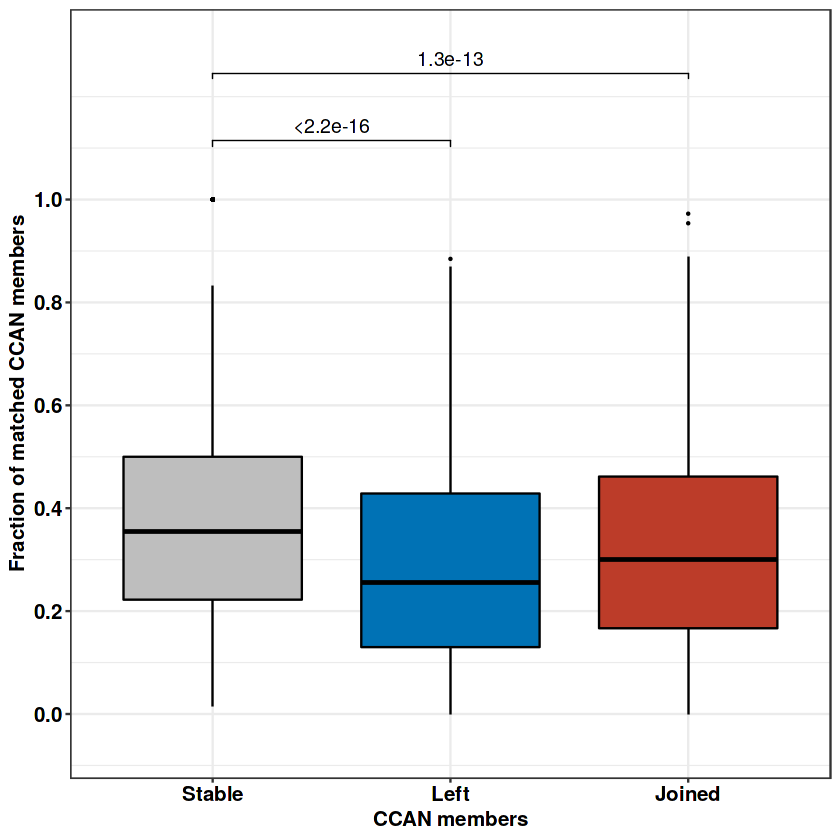

In [76]:
plt <- ggplot(maxmatched_CCAN_stats_df, aes(x=group, y=frac)) +
    geom_boxplot(aes(fill=group), color="black", outlier.size=0.2) +
    scale_y_continuous(expand=expansion(mult=c(0.1,0.1)), breaks=seq(0,1,0.2)) +
    stat_pvalue_manual(maxmatched_CCAN_stats_test, tip.length=0.01, label.size=4, label = "p.label", bracket.nudge.y = 0.1, step.increase = 0.1) +
    scale_fill_manual(values=c("grey",ggsci::pal_nejm()(2)[2:1])) +
    theme_bw() + labs(x="CCAN members", y="Fraction of matched CCAN members") +
    theme(legend.position="none",
        axis.text = element_text(size=12, face="bold", color="black"),
        axis.title = element_text(size=12, face="bold", color="black"))
plt

png(file.path(projdir,"MuSC_subset","Cicero_plots","left_joined_ccan.png"), res=300, units='in', width=2.5, height=4)
print(plt)
dev.off()

png 
  2

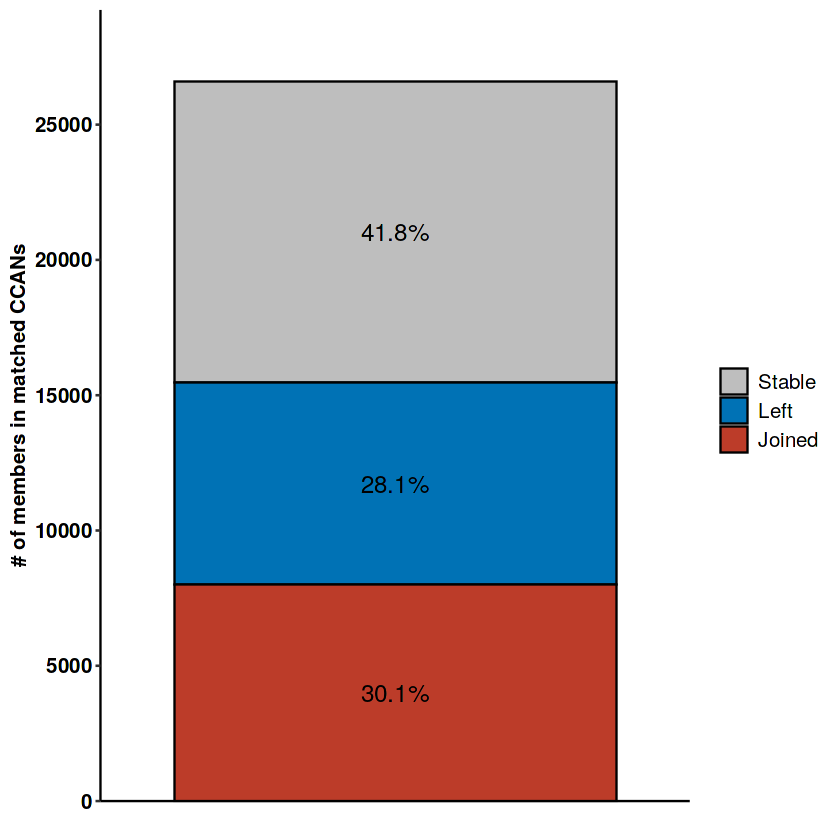

In [77]:
plt <- maxmatched_CCAN_stats_df %>%
    group_by(group) %>%
    summarise(num = sum(num)) %>%
    mutate(frac = num/sum(num)) %>%
    ggplot(aes(x="", y=num)) +
    geom_col(aes(fill=group), color = "black", position="stack") +
    geom_text(aes(label = scales::percent(frac, 0.1), group=group), size=5, position = position_stack(vjust = 0.5)) +
    scale_fill_manual(values=c("grey",ggsci::pal_nejm()(2)[2:1])) +
    scale_y_continuous(expand=expansion(mult=c(0,0.1)), breaks=seq(0,3e4,0.5e4)) +
    theme_pubr() + labs(x=NULL, y="# of members in matched CCANs") +
    theme(legend.position = "right",
        legend.title = element_blank(),
        legend.text = element_text(size=12),
        axis.text = element_text(size=12, face="bold", color="black"),
        axis.title = element_text(size=12, face="bold", color="black"),
        axis.ticks.x = element_blank())
plt

png(file.path(projdir,"MuSC_subset","Cicero_plots","left_joined_ccan_bar.png"), res=300, units='in', width=3, height=3.5)
print(plt)
dev.off()

## Compare sizes of matched and non-matched CCANs

In [78]:
aged_ccans %>%
      mutate(matched = CCAN %in% maxmatched_CCAN$Aged) %>%
      group_by(CCAN) %>%
      summarise(num_peaks = n(),
                matched_check = matched) %>%
      distinct() %>%
      ungroup() %>%
      wilcox_test(num_peaks ~ matched_check)
young_ccans %>%
      mutate(matched = CCAN %in% maxmatched_CCAN$Young) %>%
      group_by(CCAN) %>%
      summarise(num_peaks = n(),
                matched_check = matched) %>%
      distinct() %>%
      ungroup() %>%
      wilcox_test(num_peaks ~ matched_check)

`summarise()` has grouped output by 'CCAN'. You can override using the `.groups` argument.


,.y.,group1,group2,n1,n2,statistic,p
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
1,num_peaks,FALSE,TRUE,791,1174,211009,5.32e-99


`summarise()` has grouped output by 'CCAN'. You can override using the `.groups` argument.


,.y.,group1,group2,n1,n2,statistic,p
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
1,num_peaks,FALSE,TRUE,572,1174,171308,6.42e-65


In [79]:
matched_ccan_df <- rbind(aged_ccans %>% mutate(matched = CCAN %in% maxmatched_CCAN$Aged),
                         young_ccans %>% mutate(matched = CCAN %in% maxmatched_CCAN$Young)) %>%
    mutate(Age = factor(c(rep_len("Aged",nrow(aged_ccans)), rep_len("Young",nrow(young_ccans))), levels=c("Young","Aged"))) %>%
    group_by(Age, CCAN) %>%
    summarise(num_peaks = n(),
            matched_check = matched) %>%
    distinct()

`summarise()` has grouped output by 'Age', 'CCAN'. You can override using the `.groups` argument.


In [80]:
matched_ccan_age_test <- matched_ccan_df %>%
      mutate(num_peaks_log10 = log10(num_peaks)) %>%
      group_by(Age) %>%
      wilcox_test(num_peaks_log10 ~ matched_check)
matched_ccan_age_test <- matched_ccan_age_test %>% add_xy_position(x="matched_check", group="Age", dodge=0.9)
matched_ccan_age_test$p.label <- sapply(matched_ccan_age_test$p, function(x) ifelse(x<2.2e-16, "<2.2e-16", x))

In [81]:
matched_ccan_match_test <- matched_ccan_df %>%
  mutate(num_peaks_log10 = log10(num_peaks)) %>%
  group_by(matched_check) %>%
  wilcox_test(num_peaks_log10 ~ Age)
matched_ccan_match_test <- matched_ccan_match_test %>% add_xy_position(x="matched_check", group="Age", dodge=0.9)
matched_ccan_match_test$p.label <- sapply(matched_ccan_match_test$p, function(x) ifelse(x<2.2e-16, "<2.2e-16", x))

png 
  2

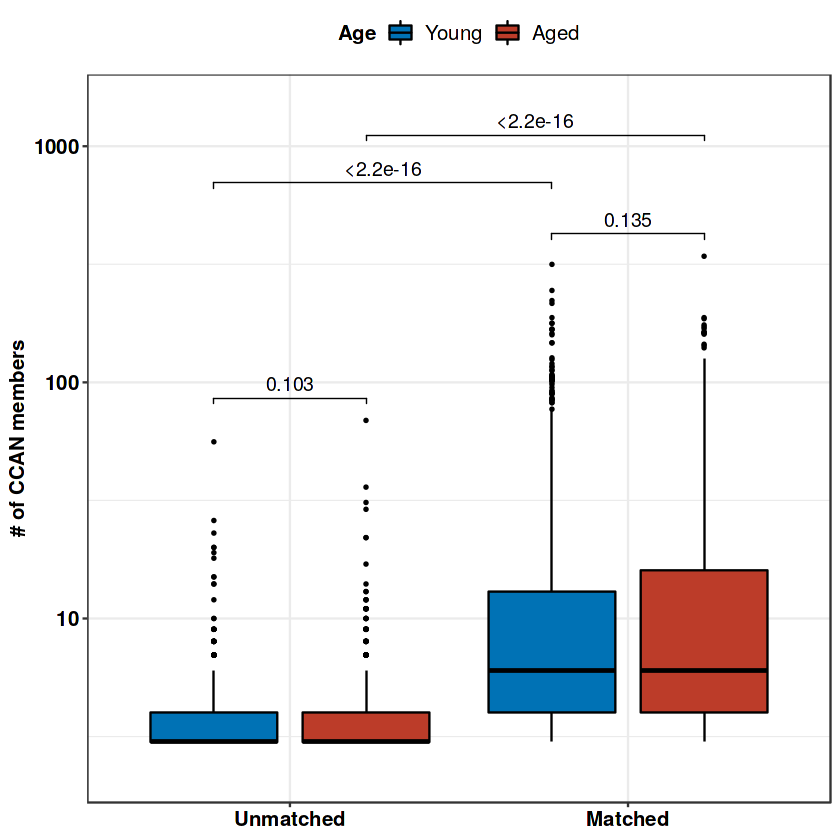

In [82]:
plt <- ggplot(matched_ccan_df, aes(x = matched_check, y=num_peaks)) + 
    geom_boxplot(aes(fill=Age), position=position_dodge(0.9), outlier.size=0.5, color="black") +
    scale_fill_manual(values=pal_nejm()(2)[c(2,1)]) +
    scale_x_discrete(labels=c("Unmatched","Matched")) +
    scale_y_log10(expand=expansion(mult=c(0.1,0.1))) +
    stat_pvalue_manual(matched_ccan_match_test, tip.length=0.01, label = "p.label", label.size=4) +
    stat_pvalue_manual(matched_ccan_age_test, tip.length=0.01, label = "p.label", label.size=4, bracket.nudge.y = 0.25, step.increase = 0.075) +
    theme_bw() + labs(x=NULL, y="# of CCAN members") +
    theme(legend.position ="top",
        axis.text = element_text(size=12, face="bold", color="black"),
        axis.title = element_text(size=12, face="bold", color="black"),
        legend.text = element_text(size=12),
        legend.title = element_text(face="bold", size=12))
plt

png(file.path(projdir, "MuSC_subset", "Cicero_plots", "merged_num_peaks_in_ccans.png"), res=300, units='in', width=3, height=4)
print(plt)
dev.off()

## Get genes within CCANs

In [77]:
gene_anno

DataFrame with 1869019 rows and 31 columns
           seqid   source       type     start       end     score      strand
        <factor> <factor>   <factor> <integer> <integer> <numeric> <character>
1           chr1  HAVANA  gene         3073253   3074322        NA           +
2           chr1  HAVANA  transcript   3073253   3074322        NA           +
3           chr1  HAVANA  exon         3073253   3074322        NA           +
4           chr1  ENSEMBL gene         3102016   3102125        NA           +
5           chr1  ENSEMBL transcript   3102016   3102125        NA           +
...          ...      ...        ...       ...       ...       ...         ...
1869015     chrM  ENSEMBL transcript     15289     15355        NA           +
1869016     chrM  ENSEMBL exon           15289     15355        NA           +
1869017     chrM  ENSEMBL gene           15356     15422        NA           -
1869018     chrM  ENSEMBL transcript     15356     15422        NA           -
1869019  

### look only at protein coding genes, convert to GenomicRanges

In [83]:
gene_anno_idx <- gene_anno$type=="gene" & gene_anno$gene_type=="protein_coding"
gene_anno_ranges <- GRanges(gene_anno[gene_anno_idx, c("seqid","start","end")])
mcols(gene_anno_ranges)$gene <- gene_anno$gene_name[gene_anno_idx]

### get genes in maxmatched CCANs

In [178]:
aged_maxmatched_genes <- get_CCAN_genes(gene_anno_ranges, unique(maxmatched_CCAN$Aged), aged_ccans)
aged_maxmatched_genes_list <- lapply(aged_maxmatched_genes, function(x) mcols(x)$gene)
summary(unlist(lapply(aged_maxmatched_genes_list, length)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    2.00    5.00   10.05   11.00  141.00 

In [187]:
young_maxmatched_genes <- get_CCAN_genes(gene_anno_ranges, unique(maxmatched_CCAN$Young), young_ccans)
young_maxmatched_genes_list <- lapply(young_maxmatched_genes, function(x) mcols(x)$gene)
summary(unlist(lapply(young_maxmatched_genes_list, length)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   5.000   9.956  11.000 139.000 

In [84]:
all_maxmatched_genes_young <- get_CCAN_genes(gene_anno_ranges, unique(all_maxmatched_CCAN_young$All), all_ccans)
all_maxmatched_genes_young_list <- lapply(all_maxmatched_genes_young, function(x) mcols(x)$gene)
summary(unlist(lapply(all_maxmatched_genes_young_list, length)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    2.00    5.00   10.54   11.00  126.00 

In [85]:
all_maxmatched_genes_aged <- get_CCAN_genes(gene_anno_ranges, unique(all_maxmatched_CCAN_aged$All), all_ccans)
all_maxmatched_genes_aged_list <- lapply(all_maxmatched_genes_aged, function(x) mcols(x)$gene)
summary(unlist(lapply(all_maxmatched_genes_aged_list, length)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   5.000   9.974  10.000 126.000 

In [188]:
write.table(unique(unlist(young_maxmatched_genes_list)), file=file.path(projdir,'MuSC_subset','young_matched_genes_list.txt'), col.names=FALSE, row.names=FALSE, quote=FALSE)
write.table(unique(unlist(aged_maxmatched_genes_list)), file=file.path(projdir,'MuSC_subset','aged_matched_genes_list.txt'), col.names=FALSE, row.names=FALSE, quote=FALSE)
write.table(unique(unlist(all_maxmatched_genes_young_list)), file=file.path(projdir,'MuSC_subset','all_matched_genes_young_list.txt'), col.names=FALSE, row.names=FALSE, quote=FALSE)
write.table(unique(unlist(all_maxmatched_genes_aged_list)), file=file.path(projdir,'MuSC_subset','all_matched_genes_aged_list.txt'), col.names=FALSE, row.names=FALSE, quote=FALSE)

### How many differentially expressed genes in CCANS?

In [1476]:
#DE.genes.symbol <- DE.genes.name %>% tidyr::separate(V1, into=c('geneid','symbol'), sep='_')
DE.genes.symbol

geneid,symbol
<chr>,<chr>
ENSMUSG00000026247,Ecel1
ENSMUSG00000093482,Gm20619
ENSMUSG00000025856,Pdgfa
ENSMUSG00000096862,Gm13301
ENSMUSG00000054863,Fam19a5
ENSMUSG00000029621,Arpc1a
ENSMUSG00000046185,Zfp84
ENSMUSG00000026385,Dbi
ENSMUSG00000085684,4930469K13Rik


In [1481]:
length(intersect(DE.genes.symbol$symbol, unlist(young_maxmatched_genes)))/length(DE.genes.symbol$symbol)

[1] 0.498376

In [1482]:
length(intersect(DE.genes.symbol$symbol, unlist(aged_maxmatched_genes)))/length(DE.genes.symbol$symbol)

[1] 0.4990978

### Get genes in unique CCANs

In [88]:
aged_unique_CCAN_genes <- get_CCAN_genes(gene_anno_ranges, aged_ccans$CCAN[!aged_ccans$CCAN %in% unique(maxmatched_CCAN$Aged)], aged_ccans)
aged_unique_genes_list <- unlist(lapply(aged_unique_CCAN_genes, function(x) if(!is.null(x)) mcols(x)$gene))

In [89]:
young_unique_CCAN_genes <- get_CCAN_genes(gene_anno_ranges, young_ccans$CCAN[!young_ccans$CCAN %in% unique(maxmatched_CCAN$Young)], young_ccans)
young_unique_genes_list <- unlist(lapply(young_unique_CCAN_genes, function(x) if(!is.null(x)) mcols(x)$gene))

In [90]:
write.table(young_unique_genes_list, file=file.path(projdir,'MuSC_subset','young_unique_genes_list.txt'), col.names=FALSE, row.names=FALSE, quote=FALSE)
write.table(aged_unique_genes_list, file=file.path(projdir,'MuSC_subset','aged_unique_genes_list.txt'), col.names=FALSE, row.names=FALSE, quote=FALSE)

In [183]:
saveRDS(list(aged_maxmatched = aged_maxmatched_genes, young_maxmatched = young_maxmatched_genes,
             all_young_maxmatched = all_maxmatched_genes_young, all_aged_maxmatched = all_maxmatched_genes_aged,
             aged_unique = aged_unique_CCAN_genes, young_unique = young_unique_CCAN_genes), 
        file.path(projdir, 'MuSC_subset', 'maxmatched_and_unique_CCAN_genes_list.RDS'))

In [92]:
#maxmatched_and_unique_CCAN_genes_list <- readRDS(file.path(projdir, 'MuSC_subset', 'maxmatched_and_unique_CCAN_genes_list.RDS'))

In [93]:
# aged_maxmatched_genes <- maxmatched_and_unique_CCAN_genes_list[['aged_maxmatched']]
# young_maxmatched_genes <- maxmatched_and_unique_CCAN_genes_list[['young_maxmatched']]
# all_aged_maxmatched_genes <- maxmatched_and_unique_CCAN_genes_list[['all_aged_maxmatched']]
# all_young_maxmatched_genes <- maxmatched_and_unique_CCAN_genes_list[['all_young_maxmatched']]

### Gene annotation with Webgestaltr

In [96]:
ccan_gene_files <- list.files(file.path(projdir, 'MuSC_subset'), pattern='_genes_list.txt', full.names = TRUE)
ccan_gene_files

[1] "/nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis/MuSC_subset/aged_matched_genes_list.txt" 
[2] "/nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis/MuSC_subset/aged_unique_genes_list.txt"  
[3] "/nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis/MuSC_subset/young_matched_genes_list.txt"
[4] "/nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis/MuSC_subset/young_unique_genes_list.txt"

In [97]:
maxmatched_webgestaltr <- list()
outdir <- file.path(projdir, 'MuSC_subset', 'Cicero_WebGestaltR')
if(!dir.exists(outdir)) dir.create(outdir, recursive = TRUE)

for(file in ccan_gene_files) {
    sample <- gsub("_genes_list.txt","",basename(file),fixed=TRUE) 
    
    # suppress warnings or 1000s of messages pop up
    suppressWarnings(
        maxmatched_webgestaltr[[sample]] <- WebGestaltR(
            enrichMethod = "ORA",
            organism = "mmusculus",
            enrichDatabase = c("geneontology_Biological_Process_noRedundant",
                               "pathway_Reactome"),
            interestGeneFile = file,
            interestGeneType = "genesymbol",
            collapseMethod = "mean",
            referenceSet = "genome",
            minNum = 10, maxNum = 2000,
            sigMethod = 'fdr', fdrMethod = 'BH', fdrThr = 0.05,
            reportNum = 40, setCoverNum = 10,
            projectName = sample,
            isOutput = TRUE, outputDirectory = outdir,
            nThreads = 30
        )
    )
}

Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
End weighted set cover...
Generate the final report...
Results can be found in the /nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis/MuSC_subset/Cicero_WebGestaltR/Project_aged_matched!
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
Remain is 0, ending weighted set cover
Generate the final report...
Results can be found in the /nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis/MuSC_subset/Cicero_WebGestaltR/Project_aged_unique!
Loading the functional categories...
Loading the ID list...
Loading the reference list...


# Look for specific genes  for connection plots

In [1579]:
length(aged_maxmatched_genes_list)

[1] 1186

In [189]:
aged_maxmatched_genes_list_df <- bind_rows(lapply(aged_maxmatched_genes, as.data.frame), .id="CCAN")
young_maxmatched_genes_list_df <- bind_rows(lapply(young_maxmatched_genes, as.data.frame), .id="CCAN")
all_maxmatched_genes_young_list_df <- bind_rows(lapply(all_maxmatched_genes_young, as.data.frame), .id="CCAN")
all_maxmatched_genes_aged_list_df <- bind_rows(lapply(all_maxmatched_genes_aged, as.data.frame), .id="CCAN")

In [457]:
target_gene <- 'Chd5'

In [458]:
young_target_ccan <- young_maxmatched_genes_list_df[young_maxmatched_genes_list_df$gene == target_gene, ];
aged_target_ccan <- aged_maxmatched_genes_list_df[aged_maxmatched_genes_list_df$gene == target_gene, ];
all_young_target_ccan <- all_maxmatched_genes_young_list_df[all_maxmatched_genes_young_list_df$gene == target_gene, ];
all_aged_target_ccan <- all_maxmatched_genes_aged_list_df[all_maxmatched_genes_aged_list_df$gene == target_gene, ];

In [459]:
young_target_ccan

,CCAN,seqnames,start,end,width,strand,gene
,<chr>,<fct>,<int>,<int>,<int>,<fct>,<chr>
5727,2916,chr4,152338651,152390194,51544,*,Chd5


## Make CCAN comparison plotgardener plot

In [460]:
young_ccan_subset <- get_ccan_subset(young_conns, young_ccans, young_target_ccan$CCAN)
young_ccan_subset <- young_ccan_subset[which(young_ccan_subset$counts>0.1),]
young_ccan_subset

GenomicInteractions object with 108 interactions and 3 metadata columns:
        seqnames1             ranges1     seqnames2             ranges2 |
            <Rle>           <IRanges>         <Rle>           <IRanges> |
    [1]      chr4 151860954-151861454 ---      chr4 152131308-152131808 |
    [2]      chr4 151861873-151862373 ---      chr4 151981315-151981815 |
    [3]      chr4 151861873-151862373 ---      chr4 151996248-151996748 |
    [4]      chr4 151861873-151862373 ---      chr4 152008633-152009133 |
    [5]      chr4 151861873-151862373 ---      chr4 152009217-152009717 |
    ...       ...                 ... ...       ...                 ... .
  [104]      chr4 152119320-152119820 ---      chr4 152477325-152477825 |
  [105]      chr4 152119840-152120340 ---      chr4 152477325-152477825 |
  [106]      chr4 152120428-152120928 ---      chr4 152477325-152477825 |
  [107]      chr4 152121094-152121594 ---      chr4 152477325-152477825 |
  [108]      chr4 152273358-152273858 -

In [461]:
aged_ccan_subset <- get_ccan_subset(aged_conns, aged_ccans, aged_target_ccan$CCAN)
aged_ccan_subset <- aged_ccan_subset[which(aged_ccan_subset$counts>0.1),]
aged_ccan_subset

GenomicInteractions object with 174 interactions and 3 metadata columns:
        seqnames1             ranges1     seqnames2             ranges2 |
            <Rle>           <IRanges>         <Rle>           <IRanges> |
    [1]      chr4 151860954-151861454 ---      chr4 151933427-151933927 |
    [2]      chr4 151860954-151861454 ---      chr4 151983535-151984035 |
    [3]      chr4 151860954-151861454 ---      chr4 151994988-151995488 |
    [4]      chr4 151860954-151861454 ---      chr4 152078056-152078556 |
    [5]      chr4 151860954-151861454 ---      chr4 152131308-152131808 |
    ...       ...                 ... ...       ...                 ... .
  [170]      chr4 152119320-152119820 ---      chr4 152339038-152339538 |
  [171]      chr4 152405563-152406063 ---      chr4 152406407-152406907 |
  [172]      chr4 152296945-152297445 ---      chr4 152406407-152406907 |
  [173]      chr4 152405563-152406063 ---      chr4 152406407-152406907 |
  [174]      chr4 152296945-152297445 -

In [462]:
all_ccan_subset <- get_ccan_subset(all_conns, all_ccans, all_aged_target_ccan$CCAN)
all_ccan_subset <- all_ccan_subset[which(all_ccan_subset$counts>0.1),]
all_ccan_subset

GenomicInteractions object with 712 interactions and 3 metadata columns:
        seqnames1             ranges1     seqnames2             ranges2 |
            <Rle>           <IRanges>         <Rle>           <IRanges> |
    [1]      chr4 151638230-151638730 ---      chr4 151861873-151862373 |
    [2]      chr4 151638230-151638730 ---      chr4 151996248-151996748 |
    [3]      chr4 151860954-151861454 ---      chr4 152068063-152068563 |
    [4]      chr4 151860954-151861454 ---      chr4 152152207-152152707 |
    [5]      chr4 151638230-151638730 ---      chr4 151861873-151862373 |
    ...       ...                 ... ...       ...                 ... .
  [708]      chr4 152296945-152297445 ---      chr4 152434773-152435273 |
  [709]      chr4 152325542-152326042 ---      chr4 152434773-152435273 |
  [710]      chr4 152008633-152009133 ---      chr4 152477325-152477825 |
  [711]      chr4 152283123-152283623 ---      chr4 152477325-152477825 |
  [712]      chr4 152296945-152297445 -

In [463]:
ccan_subset_box <- as.data.frame(boundingBox(c(young_ccan_subset, aged_ccan_subset, all_ccan_subset)))
params <- pgParams(assembly="mm10", x=0.25, width=4.5,
                  chrom=as.character(ccan_subset_box[['seqnames1']]), chromstart=ccan_subset_box[['start1']], chromend=ccan_subset_box[['end2']])
params

$assembly
[1] "mm10"

$x
[1] 0.25

$width
[1] 4.5

$chrom
[1] "chr4"

$chromstart
[1] 151638230

$chromend
[1] 152477825

attr(,"class")
[1] "pgParams"

In [464]:
outdir <- file.path(projdir, 'MuSC_subset', 'CCANPlot')
if(!dir.exists(outdir)) dir.create(outdir, recursive = TRUE)

In [465]:
png(file.path(outdir, paste0(target_gene,".png")), res=300, width=6, height=6, units="in")
pageCreate(width=6, height=6)

coaccess_ylim <- max(max(young_ccan_subset$counts), max(aged_ccan_subset$counts), max(all_ccan_subset$counts))

p2g_palette <- c('dodgerblue2','firebrick')

make_ccans_plt(young_ccan_subset, coaccess_ylim, p2g_palette, params, 1, FALSE)
make_ccans_plt(aged_ccan_subset, coaccess_ylim, p2g_palette, params, '0.1b', FALSE)
make_ccans_plt(all_ccan_subset, coaccess_ylim, p2g_palette, params, '0.1b', FALSE)

genes_plt <- plotGenes(
  params = params,
  geneHighlights = data.frame(
    "gene" = target_gene,
    "color" = c("#225EA8")
  ),
  geneBackground = "grey",
  y = 'b0.15',
  fontsize=12
)

annoGenomeLabel(plot = genes_plt, fontsize=14, params=params, y='b0.1', scale = "Kb")

pageGuideHide()
dev.off()

arches[arches1]

heatmapLegend[heatmapLegend1]



$bedpe
NULL

$chrom
[1] "chr4"

$chromstart
[1] 151638230

$chromend
[1] 152477825

$assembly
$Genome
[1] "mm10"

$TxDb
[1] "TxDb.Mmusculus.UCSC.mm10.knownGene"

$OrgDb
[1] "org.Mm.eg.db"

$gene.id.column
[1] "ENTREZID"

$display.column
[1] "SYMBOL"

$BSgenome
[1] "BSgenome.Mmusculus.UCSC.mm10"

attr(,"class")
[1] "assembly"

$color_palette
function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x556cb5d6b200>
<environment: 0x556caece4b50>

$zrange
[1] 0.1000000 0.7182782

$range
NULL

$x
[1] 0.25inches

$y
[1] 1inches

$width
[1] 4.5inches

$height
[1] 1inches

$just
[1] 0 1

$grobs
gTree[GRID.gTree.86930] 

attr(,"class")
[1] "arches"
attr(,"plotted")
[1] TRUE

arches[arches2]

heatmapLegend[heatmapLegend2]



$bedpe
NULL

$chrom
[1] "chr4"

$chromstart
[1] 151638230

$chromend
[1] 152477825

$assembly
$Genome
[1] "mm10"

$TxDb
[1] "TxDb.Mmusculus.UCSC.mm10.knownGene"

$OrgDb
[1] "org.Mm.eg.db"

$gene.id.column
[1] "ENTREZID"

$display.column
[1] "SYMBOL"

$BSgenome
[1] "BSgenome.Mmusculus.UCSC.mm10"

attr(,"class")
[1] "assembly"

$color_palette
function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x556cb5d6b200>
<environment: 0x556cc6a22e10>

$zrange
[1] 0.1000000 0.7182782

$range
NULL

$x
[1] 0.25inches

$y
[1] 2.1inches

$width
[1] 4.5inches

$height
[1] 1inches

$just
[1] 0 1

$grobs
gTree[GRID.gTree.87260] 

attr(,"class")
[1] "arches"
attr(,"plotted")
[1] TRUE

arches[arches3]

heatmapLegend[heatmapLegend3]



$bedpe
NULL

$chrom
[1] "chr4"

$chromstart
[1] 151638230

$chromend
[1] 152477825

$assembly
$Genome
[1] "mm10"

$TxDb
[1] "TxDb.Mmusculus.UCSC.mm10.knownGene"

$OrgDb
[1] "org.Mm.eg.db"

$gene.id.column
[1] "ENTREZID"

$display.column
[1] "SYMBOL"

$BSgenome
[1] "BSgenome.Mmusculus.UCSC.mm10"

attr(,"class")
[1] "assembly"

$color_palette
function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x556cb5d6b200>
<environment: 0x556d57b3b1a8>

$zrange
[1] 0.1000000 0.7182782

$range
NULL

$x
[1] 0.25inches

$y
[1] 3.2inches

$width
[1] 4.5inches

$height
[1] 1inches

$just
[1] 0 1

$grobs
gTree[GRID.gTree.87788] 

attr(,"class")
[1] "arches"
attr(,"plotted")
[1] TRUE

genes[genes1]

Warning message:
"Start label is rounded."
Warning message:
"End label is rounded."
genomeLabel[genomeLabel1]



png 
  2

## Zoomed in plot of connections at target gene body

In [466]:
target_genebody <- gene_anno[gene_anno$gene_name==target_gene & gene_anno$type=='gene',]
target_genebody <- target_genebody[,c('seqid','start','end','gene_name')]
colnames(target_genebody) <- c('chrom','start','end','gene_name')
target_genebody <- GRanges(target_genebody)
target_genebody

GRanges object with 1 range and 1 metadata column:
      seqnames              ranges strand |   gene_name
         <Rle>           <IRanges>  <Rle> | <character>
  [1]     chr4 152338651-152390194      * |        Chd5
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

In [467]:
young_ccan_subset_zoom <- subsetByOverlaps(young_ccan_subset, target_genebody, use.region="both")
aged_ccan_subset_zoom <- subsetByOverlaps(aged_ccan_subset, target_genebody, use.region="both")
all_ccan_subset_zoom <- subsetByOverlaps(all_ccan_subset, target_genebody, use.region="both")

In [468]:
ccan_subset_zoom_box <- as.data.frame(boundingBox(c(young_ccan_subset_zoom, aged_ccan_subset_zoom, all_ccan_subset_zoom)))
zoom_params <- pgParams(assembly="mm10", x=0.25, width=4.5,
                  chrom=as.character(ccan_subset_zoom_box[['seqnames1']]), chromstart=ccan_subset_zoom_box[['start1']], chromend=ccan_subset_zoom_box[['end2']])
zoom_params

$assembly
[1] "mm10"

$x
[1] 0.25

$width
[1] 4.5

$chrom
[1] "chr4"

$chromstart
[1] 152000914

$chromend
[1] 152339538

attr(,"class")
[1] "pgParams"

In [469]:
png(file.path(outdir, paste0(target_gene,"_zoom.png")), res=300, width=6, height=6, units="in")
pageCreate(width=6, height=6)

coaccess_ylim <- max(max(young_ccan_subset_zoom$counts), max(aged_ccan_subset_zoom$counts), max(all_ccan_subset_zoom$counts))

p2g_palette <- c('dodgerblue2','firebrick')

young_zoom <- make_ccans_plt(young_ccan_subset_zoom, coaccess_ylim, p2g_palette, params, 1, FALSE)
aged_zoom <- make_ccans_plt(aged_ccan_subset_zoom, coaccess_ylim, p2g_palette, params, '0.1b', FALSE)

annoHighlight(
  plot = young_zoom, alpha=0.4,
  params = zoom_params, fill = "green",
  chrom = as.character(seqnames(target_genebody)), chromstart = start(target_genebody), chromend = end(target_genebody),
  y = young_zoom$y, height = 1, just = c("left", "top"),
  default.units = "inches"
)

annoHighlight(
  plot = aged_zoom, alpha=0.4,
  params = zoom_params, fill = "green",
  chrom = as.character(seqnames(target_genebody)), chromstart = start(target_genebody), chromend = end(target_genebody),
  y = aged_zoom$y, height = 1, just = c("left", "top"),
  default.units = "inches"
)

genes_plt <- plotGenes(
  params = params,
  geneHighlights = data.frame(
    "gene" = target_gene,
    "color" = c("#225EA8")
  ),
  geneBackground = "grey",
  y = 'b0.15',
  fontsize=12
)

annoGenomeLabel(plot = genes_plt, fontsize=14, params=params, y='b0.1', scale = "Kb")

pageGuideHide()
dev.off()

arches[arches1]

heatmapLegend[heatmapLegend1]

arches[arches2]

heatmapLegend[heatmapLegend2]

highlight[highlight1]

highlight[highlight2]

genes[genes1]

Warning message:
"Start label is rounded."
Warning message:
"End label is rounded."
genomeLabel[genomeLabel1]



png 
  2

# Expression in CCANs

## Bulk expression

In [1506]:
shared_CCAN_shared_genes <- unique(intersect(unlist(aged_maxmatched_genes_list), unlist(young_maxmatched_genes_list)))
shared_CCAN_all_genes <- unique(c(unlist(aged_maxmatched_genes_list), unlist(young_maxmatched_genes_list)))

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'unique': error in evaluating the argument 'x' in selecting a method for function 'intersect': object 'aged_maxmatched_genes_list' not found


In [127]:
str(DE.genes.name)

'data.frame':	2771 obs. of  1 variable:
 $ V1: chr  "ENSMUSG00000026247_Ecel1" "ENSMUSG00000093482_Gm20619" "ENSMUSG00000025856_Pdgfa" "ENSMUSG00000096862_Gm13301" ...


In [1080]:
DE.genes.symbol <- DE.genes.name %>% tidyr::separate(V1, into=c('geneid','symbol'), sep='_')
DE.genes.symbol

geneid,symbol
<chr>,<chr>
ENSMUSG00000026247,Ecel1
ENSMUSG00000093482,Gm20619
ENSMUSG00000025856,Pdgfa
ENSMUSG00000096862,Gm13301
ENSMUSG00000054863,Fam19a5
ENSMUSG00000029621,Arpc1a
ENSMUSG00000046185,Zfp84
ENSMUSG00000026385,Dbi
ENSMUSG00000085684,4930469K13Rik


In [1131]:
grep('Hes1',DE.genes.symbol$symbol,fixed=T,value=T)

character(0)

In [1108]:
avg.tpm.data <- data.frame(Aged = rowMeans(tpm.data[,1:3]), Young = rowMeans(tpm.data[,5:7]))
avg.tpm.data

,Aged,Young
,<dbl>,<dbl>
Gnai3,6.179753e+01,128.58493944
Cdc45,3.999861e+00,10.00126669
H19,3.062073e+00,2.64229642
Scml2,1.093010e+00,1.36922004
Apoh,7.814507e-01,0.15134232
Narf,6.224506e+00,10.06785433
Cav2,3.015254e+01,73.51500556
Klf6,3.073612e+02,486.17788708
Scmh1,2.905011e+01,44.24519425


In [1109]:
avg.tpm.data['Zfp36l1',]

,Aged,Young
,<dbl>,<dbl>
Zfp36l1,503.0314,199.628


In [1505]:
shared_CCAN_DE_genes_test <- avg.tpm.data[intersect(DE.genes.symbol$symbol, shared_CCAN_all_genes), ] %>%
    drop_na() %>%
    pivot_longer(cols=everything(), names_to="Age", values_to="TPM") %>%
    mutate(log2TPM = log2(TPM)) %>%
    wilcox_test(log2TPM ~ Age)
shared_CCAN_DE_genes_test <- add_xy_position(shared_CCAN_DE_genes_test, x="Age")
shared_CCAN_DE_genes_test$p.label <- sapply(shared_CCAN_DE_genes_test$p, function(x) ifelse(x<2.2e-16,"<2.2e-16",x))

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'y' in selecting a method for function 'intersect': object 'shared_CCAN_all_genes' not found


In [148]:
shared_CCAN_DE_genes <- intersect(DE.genes.symbol$symbol, shared_CCAN_all_genes)
length(shared_CCAN_DE_genes)

[1] 1587

png 
  2

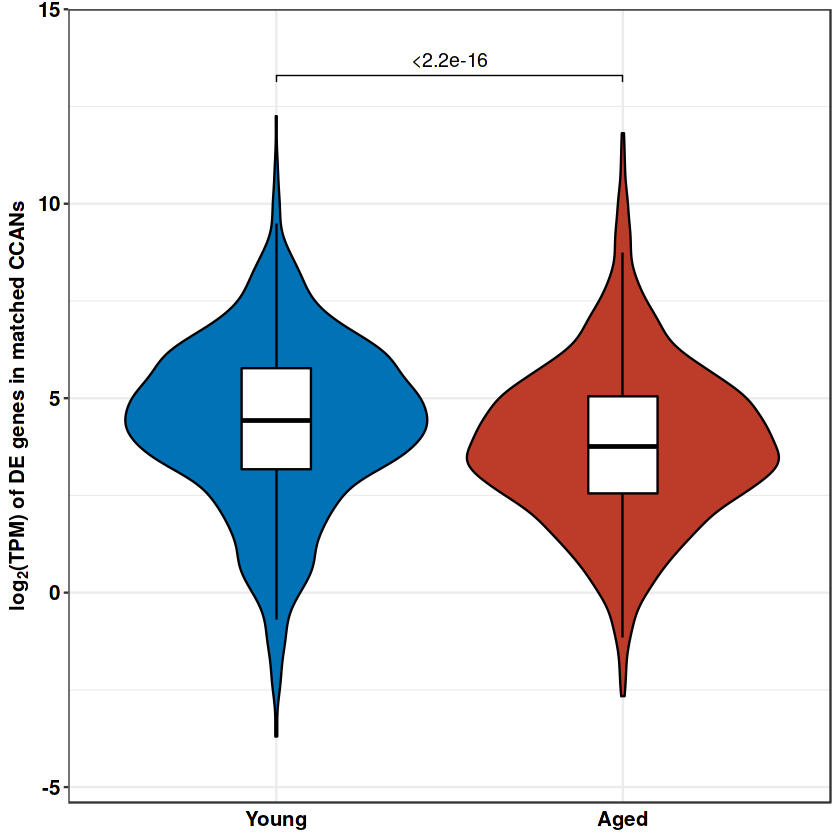

In [146]:
plt <- avg.tpm.data[shared_CCAN_DE_genes, ] %>%
    drop_na() %>%
    pivot_longer(cols=everything(), names_to="Age", values_to="TPM") %>%
    mutate(Age = factor(Age, levels=c("Young","Aged"))) %>%
    ggplot(aes(x=Age, y=log2(TPM))) +
    # stat_summary(fun.data="mean_se", geom="errorbar", width=0.5) +
    # stat_summary(fun.data="mean_se", geom="bar")
    geom_violin(aes(fill=Age), color="black") +
    geom_boxplot(color="black", width=0.2, outlier.shape=NA) +
    scale_fill_manual(values = pal_nejm()(2)[2:1]) +
    stat_pvalue_manual(shared_CCAN_DE_genes_test, label='p.label', tip.length = 0.01, label.size=4, bracket.nudge.y = 1) +
    scale_y_continuous(expand=expansion(mult=c(0.1,0.1)), breaks=seq(-5,15,5)) +
    theme_bw() + labs(x = NULL, y=expression(bold(paste("lo","g"["2"],"(TPM) of DE genes in matched CCANs")))) +
    theme(legend.position = "none",
        axis.text = element_text(size=12, face="bold", color="black"),
        axis.title = element_text(size=12, face="bold", color="black"),
        axis.ticks.x = element_blank())
plt

png(file.path(projdir,"MuSC_subset","Cicero_plots","matched_ccan_DE_genes_TPM.png"), res=300, units='in', width=2.5, height=3.6)
print(plt)
dev.off()

## Single cell expression and gene activity (use cell aggregates)

In [33]:
seATAC <- readRDS(metadata(clustered_p2g$Peak2GeneLinks)$seATAC)
seATAC

class: RangedSummarizedExperiment 
dim: 54399 613 
metadata(1): KNNList
assays(2): ATAC RawATAC
rownames(54399): f1 f2 ... f54398 f54399
rowData names(13): score replicateScoreQuantile ... idx N
colnames: NULL
colData names(0):

In [34]:
seRNA <- readRDS(metadata(clustered_p2g$Peak2GeneLinks)$seRNA)
seRNA

class: RangedSummarizedExperiment 
dim: 22699 613 
metadata(1): KNNList
assays(2): RNA RawRNA
rownames(22699): f1 f2 ... f22698 f22699
rowData names(2): name idx
colnames: NULL
colData names(0):

In [253]:
rowData(seATAC)

DataFrame with 54399 rows and 13 columns
           score replicateScoreQuantile groupScoreQuantile Reproducibility
       <numeric>              <numeric>          <numeric>       <numeric>
f1       5.56842                  0.761              0.537               3
f2      16.31540                  0.911              0.832               3
f3      10.97707                  0.602              0.280               2
f4     124.31602                  0.930              0.862               3
f5      22.24704                  0.938              0.876               3
...          ...                    ...                ...             ...
f54395   3.79443                  0.507              0.215               2
f54396   8.93627                  0.848              0.709               3
f54397   4.00478                  0.636              0.362               2
f54398  10.26240                  0.769              0.569               3
f54399   5.30172                  0.626              0.304 

In [216]:
aged_ATAC_cell_KNN <- which(clustered_p2g$ATAC$colData$groupBy == "Aged")
young_ATAC_cell_KNN <- which(clustered_p2g$ATAC$colData$groupBy == "Young")

aged_RNA_cell_KNN <- which(clustered_p2g$RNA$colData$groupBy == "Aged")
young_RNA_cell_KNN <- which(clustered_p2g$RNA$colData$groupBy == "Young")

In [252]:
se_rna_idx <- which(rowData(seRNA)$name %in% shared_CCAN_DE_genes)
seRNA_int_data <- assays(seRNA)$RawRNA[se_rna_idx, ]

my_sample_col <- data.frame(KNN = clustered_p2g$RNA$colData$groupBy)
row.names(my_sample_col) <- rownames(clustered_p2g$RNA$colData)

hmp_data <- seRNA_int_data[rowMeans(seRNA_int_data)>0,]
colnames(hmp_data) <- rownames(clustered_p2g$RNA$colData)

pheatmap::pheatmap(hmp_data, scale='row', show_colnames = FALSE, show_rownames = FALSE,
                   annotation_col = my_sample_col,
                   main = 'row-scaled raw RNA',
                   filename = file.path(projdir, 'MuSC_subset', 'Cicero_plots', 'KNN_seRNA_rawRNA_DEgenes_matched_CCANs.png'),
                   color = colorRampPalette(colors = rev(RColorBrewer::brewer.pal(11,"RdBu")))(250))

In [251]:
se_atac_idx <- which(rowData(seATAC)$nearestGene %in% shared_CCAN_DE_genes)
seATAC_data <- assays(seATAC)$RawATAC[se_atac_idx, ]

my_sample_col <- data.frame(KNN = clustered_p2g$ATAC$colData$groupBy)
row.names(my_sample_col) <- rownames(clustered_p2g$ATAC$colData)

hmp_data <- seATAC_data[rowMeans(seATAC_data)>0,]
colnames(hmp_data) <- rownames(clustered_p2g$ATAC$colData)

pheatmap::pheatmap(hmp_data, scale='row', show_colnames = FALSE, show_rownames = FALSE,
                   annotation_col = my_sample_col,
                   main = 'row-scaled raw ATAC',
                   filename = file.path(projdir, 'MuSC_subset', 'Cicero_plots', 'KNN_seATAC_rawATAC_DEgenes_matched_CCANs.png'),
                   color = colorRampPalette(colors = rev(RColorBrewer::brewer.pal(11,"RdBu")))(250))

## Single cell expression without aggregates

In [36]:
rna_int_mat <- readRDS(file.path(projdir, 'MuSC_subset', 'all_MuSC_rna_expression.RDS'))
gene_score_mat <- readRDS(file.path(projdir, 'MuSC_subset', 'all_MuSC_gene_activity.RDS'))

In [166]:
shared_CCAN_DE_genes_rna_idx <- which(rowData(rna_int_mat)$name %in% shared_CCAN_DE_genes)
shared_CCAN_DE_genes_gene_activity_idx <- which(rowData(gene_score_mat)$name %in% shared_CCAN_DE_genes)

In [151]:
aged_cell_idx <- which(colData(rna_int_mat)$Age == "Aged")
young_cell_idx <- which(colData(rna_int_mat)$Age == "Young")

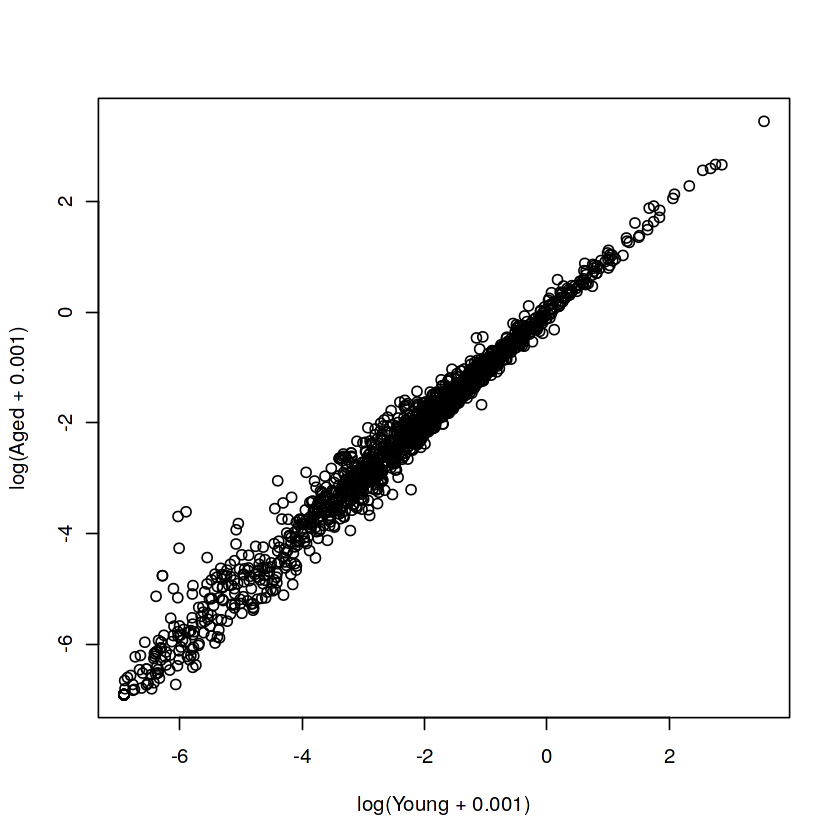

In [172]:
rna_int_data <- assays(rna_int_mat)$Harmony_4iter_GeneIntegrationMatrix[shared_CCAN_DE_genes_rna_idx, ]
rna_int_df <- data.frame(Aged = rowMeans(rna_int_data[,aged_cell_idx], na.rm=TRUE),
                         Young = rowMeans(rna_int_data[,young_cell_idx], na.rm=TRUE))
rownames(rna_int_df) <- rowData(rna_int_mat)$name[shared_CCAN_DE_genes_rna_idx]
plot(log(Aged+0.001)~log(Young+0.001), data=rna_int_df)

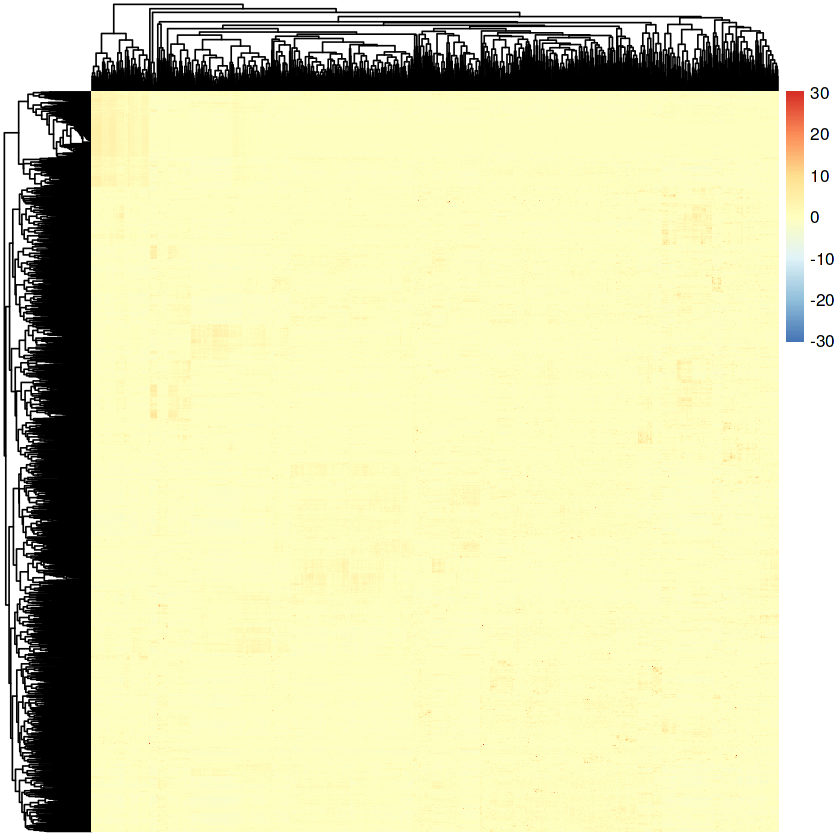

In [180]:
pheatmap::pheatmap(rna_int_data[rowSums(rna_int_data)>0,], scale='row', show_colnames = FALSE)

# Do CCANs lie in TADs?

In [716]:
## Convert CCAN data frame to GRanges
aged_ccans_ranges <- Signac::StringToGRanges(aged_ccans$Peak, sep = c("_","_"))
aged_ccans_ranges$CCAN <- aged_ccans$CCAN

young_ccans_ranges <- Signac::StringToGRanges(young_ccans$Peak, sep = c("_","_"))
young_ccans_ranges$CCAN <- young_ccans$CCAN

In [734]:
aged_ccans_ranges

GRanges object with 21415 ranges and 1 metadata column:
          seqnames              ranges strand |      CCAN
             <Rle>           <IRanges>  <Rle> | <numeric>
      [1]    chr10 100486660-100487160      * |         2
      [2]    chr10 100487163-100487663      * |         2
      [3]    chr10 100589009-100589509      * |         2
      [4]    chr10 105572764-105573264      * |         3
      [5]    chr10 105573433-105573933      * |         3
      ...      ...                 ...    ... .       ...
  [21411]     chrX   95968506-95969006      * |      5057
  [21412]     chrX   96095750-96096250      * |      5057
  [21413]     chrX   99134815-99135315      * |      5060
  [21414]     chrX   99135777-99136277      * |      5060
  [21415]     chrX   99136428-99136928      * |      5060
  -------
  seqinfo: 20 sequences from an unspecified genome; no seqlengths

In [755]:
aged.domain.ccans <- ccans_in_feature(aged_ccans_ranges, aged.domain.ranges)
young.domain.ccans <- ccans_in_feature(young_ccans_ranges, young.domain.ranges)

In [756]:
aged.domain.ccans.df <- aged.domain.ccans %>% as.data.frame() %>% mutate(Age="Aged") %>% arrange(desc(CCAN))

young.domain.ccans.df <- young.domain.ccans %>% as.data.frame() %>% mutate(Age="Young") %>% arrange(desc(CCAN))

In [784]:
# count frequency of number of TADs per CCAN
ccan_TAD_df <- rbind(young.domain.ccans.df, aged.domain.ccans.df) %>%
    mutate(Age = factor(Age, levels=c("Young","Aged"))) %>%
    group_by(Age, CCAN) %>%
    summarise(num_TADs = n_distinct(TAD, na.rm=TRUE)) %>%
    group_by(Age, num_TADs) %>%
    tally() %>%
    mutate(num_TADs = as.character(num_TADs))
ccan_TAD_df

`summarise()` has grouped output by 'Age'. You can override using the `.groups` argument.


Age,num_TADs,n
<fct>,<chr>,<int>
Young,0,19
Young,1,1098
Young,2,462
Young,3,119
Young,4,35
Young,5,15
Young,6,3
Young,7,3
Young,8,2


In [786]:
ccan_TAD_df %>% group_by(Age) %>% mutate(num_TAD_freq_frac = n/sum(n))

Age,num_TADs,n,num_TAD_freq_frac
<fct>,<chr>,<int>,<dbl>
Young,0,19,0.010820046
Young,1,1098,0.625284738
Young,2,462,0.263097950
Young,3,119,0.067767654
Young,4,35,0.019931663
Young,5,15,0.008542141
Young,6,3,0.001708428
Young,7,3,0.001708428
Young,8,2,0.001138952


png 
  2

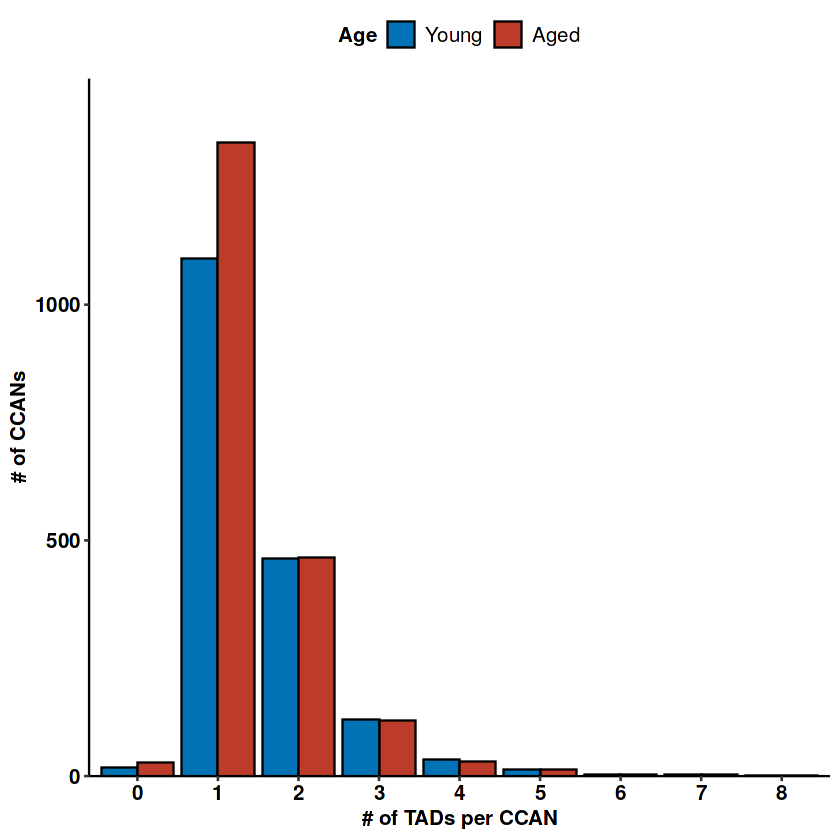

In [787]:
# Are CCAN peaks localized in the same TAD?
plt <- ggplot(ccan_TAD_df, aes(x=num_TADs, y=n)) +
    geom_col(aes(fill=Age), color="black", position="dodge") +
    scale_fill_manual(values=pal_nejm()(2)[2:1]) +
    scale_x_discrete(breaks=0:8, labels=0:8) +
    scale_y_continuous(expand = expansion(mult=c(0,0.1))) +
    theme_pubr() + labs(x="# of TADs per CCAN", y="# of CCANs") +
    theme(axis.text = element_text(face="bold"),
        axis.title = element_text(face="bold"),
        legend.title = element_text(face="bold"),
        legend.text = element_text(size=12))
plt

png(file.path(projdir,"MuSC_subset","Cicero_plots","CCAN_per_TAD_hist.png"),res=300,units='in',width=3,height=3)
print(plt)
dev.off()

In [789]:
png(file.path(projdir,"MuSC_subset","Cicero_plots","Aged_CCAN_per_TAD_hist.png"),res=300,width=4,height=4,units='in')
aged.domain.ccans.df %>% group_by(CCAN) %>% 
  summarise(num_TADs = n_distinct(TAD, na.rm=T)) %>% pull(num_TADs) %>% 
  hist(breaks=seq(-1,max(.),1), main=NULL, ylab="# of CCANs", xlab="# of TADs per CCAN")
dev.off()

png(file.path(projdir,"MuSC_subset","Cicero_plots","Young_CCAN_per_TAD_hist.png"),res=300,width=4,height=4,units='in')
young.domain.ccans.df %>% group_by(CCAN) %>%  summarise(num_TADs = n_distinct(TAD, na.rm=T)) %>% pull(num_TADs) %>% 
  hist(breaks=seq(-1,max(.),1), main=NULL, ylab="# of CCANs", xlab="# of TADs per CCAN")
dev.off()

png 
  2

png 
  2

## Get TADs that contain complete CCANs

In [264]:
aged.domain.ccans.TADs <- aged.domain.ccans.df %>% 
    group_by(TAD) %>% 
    summarise(num_CCANs = n_distinct(ccan), 
            mean_olap = mean(olap_frac)) %>% 
    dplyr::filter(num_CCANs==1 & mean_olap==1) %>% pull(TAD)

young.domain.ccans.TADs <- young.domain.ccans.df %>% 
    group_by(TAD) %>% 
    summarise(num_CCANs = n_distinct(ccan), 
            mean_olap = mean(olap_frac)) %>% 
    dplyr::filter(num_CCANs==1 & mean_olap==1) %>% pull(TAD)

In [265]:
merged.classified.stats = readRDS(file.path("/nas/homes/benyang/HiC/08_HiCExplorer/hicInterIntraTAD/merged.classified.stats.RDS"))

## What is the fraction of CCANs that are completely within a TAD per TAD rearrangement type?

png 
  2

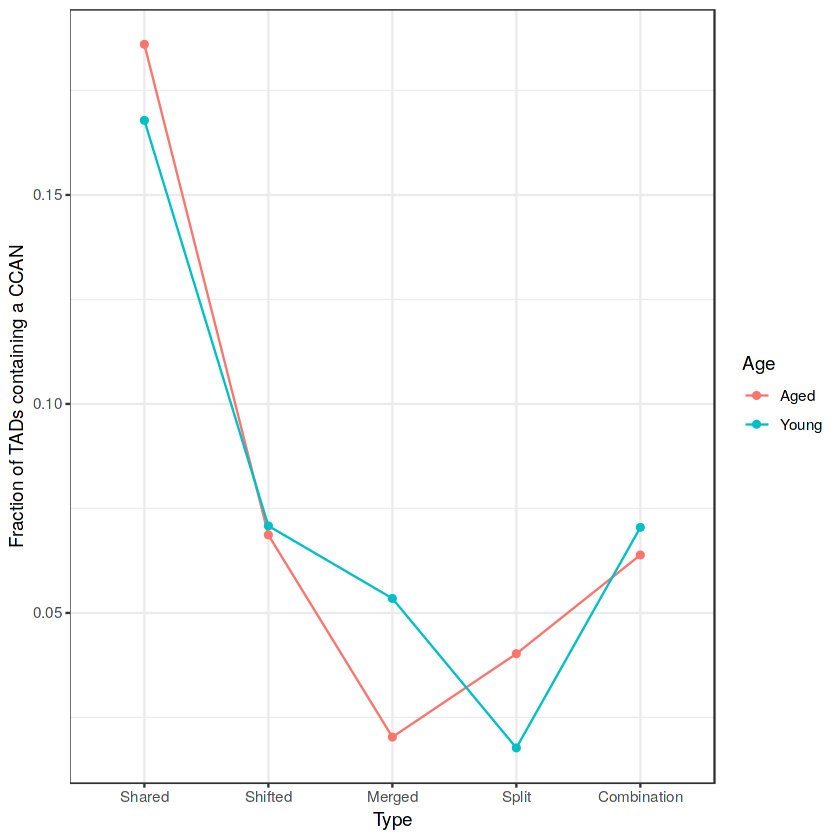

In [267]:
plt <-rbind(merged.classified.stats %>% 
        dplyr::filter(Age=="Y") %>% 
        group_by(Type) %>%
        summarise(in_tad = sum(name %in% young.domain.ccans.TADs),
                  num_total = n()) %>%
        ungroup() %>%
        mutate(frac = in_tad/sum(num_total), Age="Young"),
      merged.classified.stats %>% 
        dplyr::filter(Age=="A") %>% 
        group_by(Type) %>%
        summarise(in_tad = sum(name %in% aged.domain.ccans.TADs),
                  num_total = n()) %>%
        ungroup() %>%
        mutate(frac = in_tad/sum(num_total), Age="Aged")) %>%
  ggplot(aes(x=Type, y=frac, color=Age, group=Age)) +
  geom_path() +
  geom_point() + 
  theme_bw() +
  labs(y="Fraction of TADs containing a CCAN") 
plt

png(file.path(projdir,"MuSC_subset","Cicero_plots","CCAN_per_TAD_rearrangement.png"), res=300, units='in', width=5, height=3)
print(plt)
dev.off()

# Do CCANs lie in loops?

In [808]:
aged.loop.ranges <- aged_loop[,1:6] %>% setNames(c("chr1","start1","end1","chr2","start2","end2")) %>% distinct() %>% mutate(ID = paste0("loop",1:n()))
aged.loop.domains <- aged.loop.ranges %>% dplyr::select(chr1, start1, end2, ID) %>% setNames(c("chr","start","end","ID")) %>% GRanges()

young.loop.ranges <- young_loop[,1:6] %>% setNames(c("chr1","start1","end1","chr2","start2","end2")) %>% distinct() %>% mutate(ID = paste0("loop",1:n()))
young.loop.domains <- young.loop.ranges %>% dplyr::select(chr1, start1, end2, ID) %>% setNames(c("chr","start","end","ID")) %>% GRanges()

In [809]:
aged.loop.domains

GRanges object with 2877 ranges and 1 metadata column:
         seqnames              ranges strand |          ID
            <Rle>           <IRanges>  <Rle> | <character>
     [1]    chr10 117450000-117700000      * |       loop1
     [2]    chr10   34000000-34300000      * |       loop2
     [3]    chr10   77275000-77525000      * |       loop3
     [4]    chr10   59875000-60025000      * |       loop4
     [5]    chr10   78275000-78400000      * |       loop5
     ...      ...                 ...    ... .         ...
  [2873]     chr9   66625000-66950000      * |    loop2873
  [2874]     chr9   25150000-25600000      * |    loop2874
  [2875]     chr9   25650000-26775000      * |    loop2875
  [2876]     chr9   53975000-54350000      * |    loop2876
  [2877]     chr9   46725000-47725000      * |    loop2877
  -------
  seqinfo: 20 sequences from an unspecified genome; no seqlengths

In [810]:
aged.loop.domain.ccans <- ccans_in_feature(aged_ccans_ranges, aged.loop.domains)
young.loop.domain.ccans <- ccans_in_feature(young_ccans_ranges, young.loop.domains)

In [811]:
aged.loop.domain.ccans.df <- aged.loop.domain.ccans %>% as.data.frame() %>% mutate(Age="Aged") %>% arrange(desc(CCAN))

young.loop.domain.ccans.df <- young.loop.domain.ccans %>% as.data.frame() %>% mutate(Age="Young") %>% arrange(desc(CCAN))

## count frequency of number of loops per CCAN

In [813]:
ccan_loop_df <- rbind(young.loop.domain.ccans.df, aged.loop.domain.ccans.df) %>%
  mutate(Age = factor(Age, levels=c("Young","Aged"))) %>%
  group_by(Age, CCAN) %>%
  summarise(num_loops = n_distinct(ID, na.rm=T)) %>%
  group_by(Age, num_loops) %>%
  tally() %>%
  mutate(num_loops = factor(num_loops, levels=0:max(num_loops)))

`summarise()` has grouped output by 'Age'. You can override using the `.groups` argument.


In [814]:
ccan_loop_df %>% group_by(Age) %>% mutate(num_loop_freq_frac = n/sum(n)) %>% as.data.frame()

Age,num_loops,n,num_loop_freq_frac
<fct>,<fct>,<int>,<dbl>
Young,0,463,0.2636674260
Young,1,741,0.4219817768
Young,2,309,0.1759681093
Young,3,120,0.0683371298
Young,4,55,0.0313211845
Young,5,27,0.0153758542
Young,6,16,0.0091116173
Young,7,10,0.0056947608
Young,8,6,0.0034168565


png 
  2

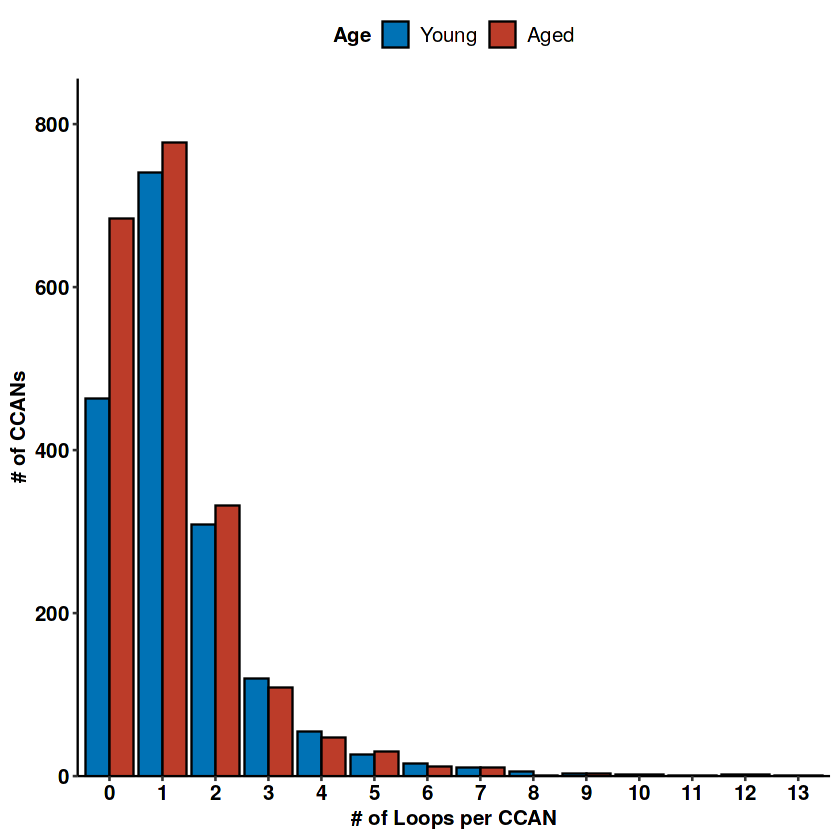

In [816]:
plt <- ggplot(ccan_loop_df, aes(x=num_loops, y=n)) +
    geom_col(aes(fill=Age), color="black", position="dodge") +
    scale_fill_manual(values=pal_nejm()(2)[2:1]) +
    scale_x_discrete(breaks=0:14, labels=0:14) +
    scale_y_continuous(expand = expansion(mult=c(0,0.1))) +
    theme_pubr() + labs(x="# of Loops per CCAN", y="# of CCANs") +
    theme(axis.text = element_text(face="bold"),
        axis.title = element_text(face="bold"),
        legend.title = element_text(face="bold"),
        legend.text = element_text(size=12))
plt

png(file.path(projdir,"MuSC_subset","Cicero_plots","CCAN_per_loop_hist.png"),res=300,units='in',width=3.5,height=3)
print(plt)
dev.off()

In [819]:
# Are CCAN peaks localized in the same loop?
png(file.path(projdir,"MuSC_subset","Cicero_plots","Aged_loop_per_CCAN_hist.png"),res=300,width=4,height=4,units='in')
aged.loop.domain.ccans.df %>% group_by(CCAN) %>% summarise(num_loops = n_distinct(ID, na.rm=T)) %>% pull(num_loops) %>% 
  hist(breaks=seq(-1,max(.),1), main=NULL, ylab="# of CCANs", xlab="# of loops per CCAN")
dev.off()

png(file.path(projdir,"MuSC_subset","Cicero_plots","Young_loop_per_CCAN_hist.png"),res=300,width=4,height=4,units='in')
young.loop.domain.ccans.df %>% group_by(CCAN) %>% summarise(num_loops = n_distinct(ID, na.rm=T)) %>% pull(num_loops) %>% 
  hist(breaks=seq(-1,max(.),1), main=NULL, ylab="# of CCANs", xlab="# of loops per CCAN")
dev.off()

png 
  2

png 
  2

## compare loops with Cicero connections

In [282]:
young_loop_bedpe <- young_loop %>% 
  unite(c("chromosome1","x1","x2"), col="Peak1", sep="_") %>%
  unite(c("chromosome2","y1","y2"), col="Peak2", sep="_") %>%
  mutate(coaccess = 1) %>%
  dplyr::select(c(Peak1,Peak2,coaccess))

aged_loop_bedpe <- aged_loop %>% 
  unite(c("chromosome1","x1","x2"), col="Peak1", sep="_") %>%
  unite(c("chromosome2","y1","y2"), col="Peak2", sep="_") %>%
  mutate(coaccess = 1) %>%
  dplyr::select(c(Peak1,Peak2,coaccess))

In [287]:
aged_conns$in_aged_loop <- compare_connections(aged_conns, aged_loop_bedpe, maxgap=2500)
young_conns$in_young_loop <- compare_connections(young_conns, young_loop_bedpe, maxgap=2500)

In [289]:
table(aged_conns$in_aged_loop)
table(young_conns$in_young_loop)


  FALSE    TRUE 
2292600   21478 


  FALSE    TRUE 
2131202   20030 

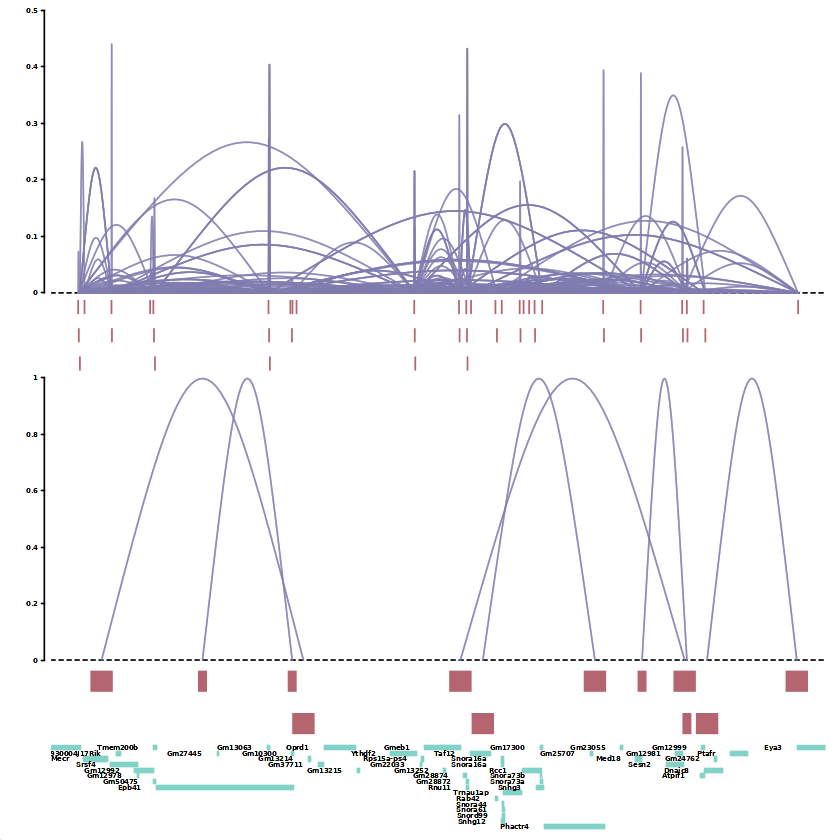

In [291]:
plot_connections(aged_conns, "chr4", 131806229, 132668392, 
                 gene_model = as.data.frame(gene_anno), 
                 coaccess_cutoff = 0,
                 connection_width = 1,
                 comparison_track = young_loop_bedpe,
                 comparison_connection_width = 1,
                 include_axis_track = FALSE,
                 collapseTranscripts = "longest")

# Cicero connection plots

## Load and prepare scATAC bigwigs

In [19]:
young_scATAC_bw <- readBigwig(file.path(projdir,"output","GroupBigWigs","Age","Young-TileSize-100-normMethod-ReadsInTSS-ArchR.bw"))
aged_scATAC_bw <- readBigwig(file.path(projdir,"output","GroupBigWigs","Age","Aged-TileSize-100-normMethod-ReadsInTSS-ArchR.bw"))

In [20]:
assign_ylim <- function(bw1, bw2) {
  ymax <- max(quantile(bw1$score, probs=c(0.999)),
              quantile(bw2$score, probs=c(0.999)))
  ylim <- c(0, ymax)
  bw1$score[bw1$score < ylim[1]] <- ylim[1]
  bw1$score[bw1$score > ylim[2]] <- ylim[2]
  bw2$score[bw2$score < ylim[1]] <- ylim[1]
  bw2$score[bw2$score > ylim[2]] <- ylim[2]
  return(list(bw1, bw2))
}


In [21]:
scATAC_ylim <- assign_ylim(young_scATAC_bw, aged_scATAC_bw)
young_scATAC_bw <- scATAC_ylim[[1]]
aged_scATAC_bw <- scATAC_ylim[[2]]

## Get peak set

In [22]:
peaks <- metadata(clustered_p2g$Peak2GeneLinks)$peakSet
peaks

GRanges object with 54399 ranges and 0 metadata columns:
          seqnames              ranges strand
             <Rle>           <IRanges>  <Rle>
      [1]     chr1     3670539-3671039      *
      [2]     chr1     3671560-3672060      *
      [3]     chr1     4571643-4572143      *
      [4]     chr1     4785442-4785942      *
      [5]     chr1     4807545-4808045      *
      ...      ...                 ...    ...
  [54395]     chrX 169862852-169863352      *
  [54396]     chrX 169879276-169879776      *
  [54397]     chrX 169881271-169881771      *
  [54398]     chrX 169881820-169882320      *
  [54399]     chrX 169890719-169891219      *
  -------
  seqinfo: 20 sequences from an unspecified genome; no seqlengths

## Get connections and P2G linkages around the target gene

In [23]:
p2g_bedpe_GI <- p2g_bedpe$bedpe_GI
p2g_bedpe_GI <- p2g_bedpe_GI[p2g_bedpe_GI$counts>0.45,]
p2g_bedpe_GI

GenomicInteractions object with 65507 interactions and 1 metadata column:
          seqnames1             ranges1     seqnames2             ranges2 |
              <Rle>           <IRanges>         <Rle>           <IRanges> |
      [1]      chr1     4785692-4785693 ---      chr1     5070285-5070286 |
      [2]      chr1     4785726-4785727 ---      chr1     4858619-4858620 |
      [3]      chr1     4807893-4807894 ---      chr1     4858619-4858620 |
      [4]      chr1     4858619-4858620 ---      chr1     5070285-5070286 |
      [5]      chr1     9545314-9545315 ---      chr1   10038159-10038160 |
      ...       ...                 ... ...       ...                 ... .
  [65503]      chrX 166344767-166344768 ---      chrX 166479867-166479868 |
  [65504]      chrX 167049461-167049462 ---      chrX 167382749-167382750 |
  [65505]      chrX 167209218-167209219 ---      chrX 167382794-167382795 |
  [65506]      chrX 169320372-169320373 ---      chrX 169320404-169320405 |
  [65507]     

In [16]:
gene_anno_df <- as.data.frame(gene_anno)

In [1456]:
target_gene <- "Klf4"

In [1457]:
viewpoint <- gene_anno_df %>% 
    dplyr::filter(gene_name==target_gene & type=='gene') %>% 
    dplyr::select(seqid, start, end, symbol) %>% 
    setNames(c('seqnames','start','end','symbol')) %>%
    GRanges()
#viewpoint <- GRanges(seqnames=viewpoint[[1]], IRanges(start=as.numeric(viewpoint[[2]]), end=as.numeric(viewpoint[[3]])))
viewpoint

GRanges object with 1 range and 1 metadata column:
      seqnames            ranges strand |      symbol
         <Rle>         <IRanges>  <Rle> | <character>
  [1]     chr4 55527143-55532466      * |        Klf4
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

In [1458]:
target_gene_hits <- findOverlaps(p2g_bedpe_GI, viewpoint, type='any')
p2g_ranges_subset <- p2g_bedpe_GI[from(target_gene_hits), ]
p2g_ranges_subset

GenomicInteractions object with 0 interactions and 1 metadata column:
   seqnames1   ranges1     seqnames2   ranges2 |    counts
       <Rle> <IRanges>         <Rle> <IRanges> | <numeric>
  -------
  regions: 49759 ranges and 0 metadata columns
  seqinfo: 20 sequences from an unspecified genome; no seqlengths

In [1447]:
p2g_bound <- c(min(start(anchorOne(p2g_ranges_subset)), start(anchorTwo(p2g_ranges_subset))),
               max(end(anchorOne(p2g_ranges_subset)), end(anchorTwo(p2g_ranges_subset))))
p2g_bound

[1] 72980446 73386653

In [1527]:
young_subset_conns <- unique(c(subsetByFeatures(GIObject = young_conns_gi, features = anchorOne(p2g_ranges_subset)),
                               subsetByFeatures(GIObject = young_conns_gi, features = anchorTwo(p2g_ranges_subset))))
young_subset_conns <- young_subset_conns[which(young_subset_conns$coaccess>0.1), ]

aged_subset_conns <- unique(c(subsetByFeatures(GIObject = aged_conns_gi, features = anchorOne(p2g_ranges_subset)),
                              subsetByFeatures(GIObject = aged_conns_gi, features = anchorTwo(p2g_ranges_subset))))
aged_subset_conns <- aged_subset_conns[which(aged_subset_conns$coaccess>0.1), ]

In [1528]:
conns_bound <- c(min(start(anchorOne(young_subset_conns)), start(anchorTwo(young_subset_conns)), start(anchorOne(aged_subset_conns)), start(anchorTwo(aged_subset_conns))),
                 max(end(anchorOne(young_subset_conns)), end(anchorTwo(young_subset_conns)), end(anchorOne(aged_subset_conns)), end(anchorTwo(aged_subset_conns))))
conns_bound

[1] 8713202 9082876

In [1529]:
young_subset_conns <- as.data.frame(young_subset_conns)[,c("seqnames1","start1","end1","seqnames2","start2","end2","coaccess","distance")]
young_subset_conns$h <- young_subset_conns$distance / max(young_subset_conns$distance)
aged_subset_conns <- as.data.frame(aged_subset_conns)[,c("seqnames1","start1","end1","seqnames2","start2","end2","coaccess","distance")]
aged_subset_conns$h <- aged_subset_conns$distance / max(aged_subset_conns$distance)

In [1530]:
aged_subset_conns

seqnames1,start1,end1,seqnames2,start2,end2,coaccess,distance,h
<fct>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>
chr19,8723005,8723505,chr19,8756777,8757277,0.2037544,33772,0.11096216
chr19,8723005,8723505,chr19,8798346,8798846,0.1090118,75341,0.24754235
chr19,8723005,8723505,chr19,8819065,8819565,0.1511557,96060,0.31561724
chr19,8735580,8736080,chr19,8871269,8871769,0.3489233,135689,0.44582331
chr19,8741101,8741601,chr19,8837279,8837779,0.1485273,96178,0.31600494
chr19,8741101,8741601,chr19,8984432,8984932,0.1522063,243331,0.79949467
chr19,8741101,8741601,chr19,8990004,8990504,0.1198197,248903,0.81780218
chr19,8756777,8757277,chr19,8774508,8775008,0.1089912,17731,0.05825744
chr19,8756777,8757277,chr19,8798346,8798846,0.4562432,41569,0.13658019


## Prepare gene expression plot

In [1451]:
target_gene_idx <- which(rowData(seRNA)$name == target_gene)
rna_data <- assays(rna_int_mat)$Harmony_4iter_GeneIntegrationMatrix[target_gene_idx, ]

In [1452]:
target_gene_idx <- which(rowData(seRNA)$name == target_gene)
rna_data <- assays(rna_int_mat)$Harmony_4iter_GeneIntegrationMatrix[target_gene_idx, ]

target_gene_rna <- data.frame(values = rna_data,
                              Age = factor(colData(rna_int_mat)$Age, levels=c("Aged","Young")))
# young_target_gene_rna = target_gene_rna[which(colData(gene_int_mat)$Age=="Young")]
# aged_target_gene_rna = target_gene_rna[which(colData(gene_int_mat)$Age=="Aged")]

In [1453]:
wilcox_test(data=target_gene_rna, values~Age)

,.y.,group1,group2,n1,n2,statistic,p
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
1,values,Aged,Young,457,540,114587,0.052


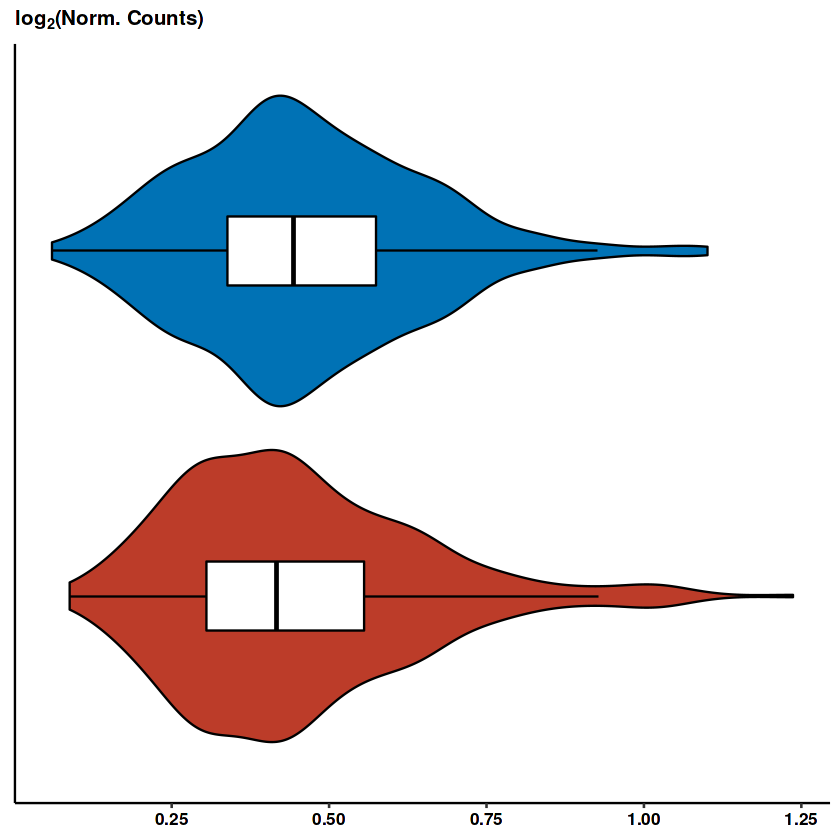

In [1454]:
rna_plt <- ggplot(target_gene_rna, aes(x=values, y=Age)) +
  geom_violin(aes(fill=Age), color="black") +
  geom_boxplot(width=0.2, outlier.shape=NA, color="black") +
  #scale_x_continuous(limits = c(0,12.5), breaks=seq(0,12.5,5)) +
  theme_pubr() + labs(x=NULL, y=NULL, title=expression(bold(paste("lo","g"["2"],"(Norm. Counts)")))) +
  scale_fill_manual(values=pal_nejm()(2)) +
  theme(axis.text.x = element_text(color='black', face="bold", size=10),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        title = element_text(size=10),
        legend.position = "none")
rna_plt

In [1455]:
'Hr' %in% DE.genes.name

[1] FALSE

## Set up viewpoints for target gene

In [1374]:
viewpoint

GRanges object with 1 range and 1 metadata column:
      seqnames            ranges strand |      symbol
         <Rle>         <IRanges>  <Rle> | <character>
  [1]     chr3 94372794-94398276      * |        Rorc
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

In [1429]:
plot_region <- c(as.character(seqnames(viewpoint)),
                 min(start(viewpoint), p2g_bound[1], conns_bound[1]) - 5e4,
                 max(end(viewpoint), p2g_bound[2], conns_bound[2]) + 5e4)

plot_region_ranges <- GRanges(data.frame(seqnames=plot_region[1], start=plot_region[2], end=plot_region[3]))

In [1430]:
params <- pgParams(assembly="mm10", x=0.25, width=4.5,
                  chrom=plot_region[1], chromstart=as.integer(plot_region[2]), chromend=as.integer(plot_region[3]))

In [1431]:
plot_region

[1] "chr15"     "101874735" "103290544"

## Make plotgardener plot components

### Make scATAC signals

In [143]:
make_scATAC_signals <- function() {
    young_scATAC_plt <- plotSignal(
        young_scATAC_bw,
        y=0, height=1, 
        fill = pal_nejm()(2)[2],
        linecolor = pal_nejm()(2)[2], scale = FALSE,
        range = c(0, 3), lwd = 1.5,
        params = params)

    aged_scATAC_plt <- plotSignal(
        aged_scATAC_bw, 
        y='0b', height=1,
        fill = pal_nejm()(2)[1],
        linecolor = pal_nejm()(2)[1], scale = FALSE,
        range = c(0, 3), lwd = 1.5,
        params = params)

    plotRect(
        x = as.numeric(gsub("inches","",params$x,fixed=TRUE)), 
        y = c(as.numeric(gsub("inches","",young_scATAC_plt$y,fixed=TRUE)),
              as.numeric(gsub("inches","",aged_scATAC_plt$y,fixed=TRUE))),
        params = params, height = 1, linecolor = "darkgray",
        just = c("left", "top"), default.units = "inches",
        lwd = 1, fill = NA
    )
    
    return(c(young_scATAC_plt$width, young_scATAC_plt$y))
}

### Make peak plot

In [134]:
make_peak_plt <- function() {
    peak_plt <- plotRanges(peaks, params=params, fill="black", y="0.15b", height=0.15, collapse=T)

    plotRect(
      x = as.numeric(gsub("inches","",params$x,fixed=T)), 
      y = as.numeric(gsub("inches","",peak_plt$y,fixed=T)) - 0.075,
      params = params, height = 0.3, linecolor = "darkgray",
      just = c("left", "top"), default.units = "inches",
      lwd = 1, fill = NA
    )
}

### Make P2G linkage plot

In [135]:
make_p2g_plt <- function() {
    p2g_ranges_subset$h <- pairdist(p2g_ranges_subset)
    p2g_ranges_subset$h <- p2g_ranges_subset$h / max(p2g_ranges_subset$h)

    p2g_plt <- plotPairsArches(p2g_ranges_subset, height=1, y='0.15b', flip = TRUE,
                               fill=colorby("counts", palette=colorRampPalette(c("#E6E7E8","#3A97FF","#8816A7","black")),
                                            range = c(0.45, max(p2g_ranges_subset$counts))),
                               archHeight = 'h', linecolor = "fill", alpha=0.6, params=params)

    annoHeatmapLegend(
      plot = p2g_plt, fontcolor = "black",
      ticks = FALSE, digits=2,
      params=params,
      x=as.numeric(gsub("inches","",p2g_plt$width,fixed=T)) + 0.5,
      y=as.numeric(gsub("inches","",p2g_plt$y,fixed=T)) + 0.125,
      width = 0.10, height = 0.75, fontsize = 10
    )

    plotRect(
      x = as.numeric(gsub("inches","",params$x,fixed=T)), 
      y = as.numeric(gsub("inches","",p2g_plt$y,fixed=T)),
      params = params, height = p2g_plt$height,
      just = c("left", "top"), default.units = "inches",
      lwd = 1, fill = NA, linecolor = "darkgray"
    )
}

### Make Cicero connections plot

In [514]:
make_conns_plt <- function() {
    coaccess_ylim <- max(max(young_subset_conns$coaccess), max(aged_subset_conns$coaccess))

    #p2g_palette <- ArchR::paletteDiscrete(set='horizonExtra', values=as.character(1:10))
    #p2g_palette <- ArchR::paletteDiscrete(set='greyMagma', values=as.character(1:10))
    p2g_palette <- c('dodgerblue2','firebrick')
    
    young_conns_plt <- plotPairsArches(young_subset_conns, height=1, y='0.1b', flip = TRUE,
                                       fill=colorby("coaccess", palette=colorRampPalette(p2g_palette),
                                                    range = c(0.1, coaccess_ylim)),
                                       archHeight = 'h', linecolor = "fill", alpha=0.6, params=params)

    annoHeatmapLegend(
      plot = young_conns_plt, fontcolor = "black",
      ticks = FALSE, digits=2,
      params=params,
      x=as.numeric(gsub("inches","",young_conns_plt$width,fixed=TRUE)) + 0.5,
      y=as.numeric(gsub("inches","",young_conns_plt$y,fixed=TRUE)) + 0.125,
      width = 0.10, height = 0.75, fontsize = 10
    )

    aged_conns_plt <- plotPairsArches(aged_subset_conns, height=1, y='0.1b', flip = T,
                                      fill=colorby("coaccess", palette=colorRampPalette(p2g_palette),
                                                   range = c(0.1, coaccess_ylim)),
                                      archHeight = 'h', linecolor = "fill", alpha=0.6, params=params)

    annoHeatmapLegend(
      plot = aged_conns_plt, fontcolor = "black",
      ticks = FALSE, digits=2,
      params=params,
      x=as.numeric(gsub("inches","",aged_conns_plt$width,fixed=T)) + 0.5,
      y=as.numeric(gsub("inches","",aged_conns_plt$y,fixed=T)) + 0.125,
      width = 0.10, height = 0.75, fontsize = 10
    )

    plotRect(
      x = as.numeric(gsub("inches","",params$x,fixed=TRUE)), 
      y = c(as.numeric(gsub("inches","",young_conns_plt$y,fixed=TRUE)),
            as.numeric(gsub("inches","",aged_conns_plt$y,fixed=TRUE))),
      params = params, height = young_conns_plt$height,
      just = c("left", "top"), default.units = "inches",
      lwd = 1, fill = NA, linecolor = "darkgray"
    )
}

### Make TAD plot

In [137]:
make_TAD_plt <- function() {
    young_TAD_plt <- plotRanges(young.domain.ranges, params=params, fill=pal_nejm()(2)[2], y="0b", height=0.5)
    aged_TAD_plt <- plotRanges(aged.domain.ranges, params=params, fill=pal_nejm()(2)[1], y="0b", height=0.5)

    plotRect(
      x = as.numeric(gsub("inches","",params$x,fixed=T)), 
      y = as.numeric(gsub("inches","",young_TAD_plt$y,fixed=T)) + 0.15,
      params = params, height = 2 * young_TAD_plt$height,
      just = c("left", "top"), default.units = "inches",
      lwd = 1, fill = NA, linecolor = "darkgray"
    )
}

## Assemble final plot

In [138]:
outdir <- file.path(projdir, 'MuSC_subset', 'CoveragePlots')
if(!dir.exists(outdir)) dir.create(outdir, recursive = TRUE)

In [1432]:
png(file.path(outdir, paste0(target_gene,".png")), res=300, width=7, height=8, units="in")
pageCreate(width=7, height=8)

top_y_coord <- make_scATAC_signals()
make_peak_plt()
make_p2g_plt()
make_conns_plt()
make_TAD_plt()

genes_plt <- plotGenes(
  params = params,
  geneHighlights = data.frame(
    "gene" = target_gene,
    "color" = c("#225EA8")
  ),
  geneBackground = "grey",
  y = 'b0.15',
  fontsize=12
)

annoGenomeLabel(plot = genes_plt, fontsize=14, params=params, y='b0.1', scale = "Kb")

plotGG(rna_plt, 
       params=params,
       x=as.numeric(gsub("inches","",top_y_coord[1],fixed=TRUE)) + 0.3,
       y=as.numeric(gsub("inches","",top_y_coord[2],fixed=TRUE)),
       width = 1.75, height = 2.25)

pageGuideHide()
dev.off()

signal[signal1]

signal[signal2]

rect[rect1]

ranges[ranges1]

rect[rect2]

arches[arches1]

heatmapLegend[heatmapLegend1]

rect[rect2]

arches[arches2]

heatmapLegend[heatmapLegend2]

arches[arches3]

heatmapLegend[heatmapLegend3]

rect[rect2]

ranges[ranges2]

ranges[ranges3]

rect[rect2]

genes[genes1]

Warning message:
"Start label is rounded."
Warning message:
"End label is rounded."
genomeLabel[genomeLabel1]

gg[gg1]



png 
  2

In [1067]:
aged_conns_gi[which(aged_conns_gi$coaccess>0.1),]

StrictGInteractions object with 39984 interactions and 12 metadata columns:
          seqnames1             ranges1     seqnames2             ranges2 |
              <Rle>           <IRanges>         <Rle>           <IRanges> |
      [1]     chr10 100015265-100015765 ---     chr10 100015912-100016412 |
      [2]     chr10 100486660-100487160 ---     chr10 100487163-100487663 |
      [3]     chr10 100486660-100487160 ---     chr10 100589009-100589509 |
      [4]     chr10 105572764-105573264 ---     chr10 105574251-105574751 |
      [5]     chr10 105573433-105573933 ---     chr10 105574251-105574751 |
      ...       ...                 ... ...       ...                 ... .
  [39980]      chrX   99199061-99199561 ---      chrX   99199596-99200096 |
  [39981]      chrX   99290764-99291264 ---      chrX   99291511-99292011 |
  [39982]      chrX   99656939-99657439 ---      chrX   99657993-99658493 |
  [39983]      chrX   99853098-99853598 ---      chrX   99975214-99975714 |
  [39984]   